# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


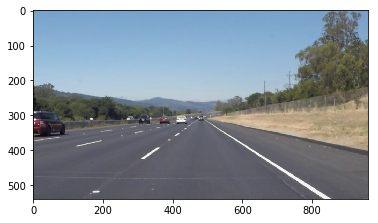

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [253]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    index = 0
    #use some colors to see which lines are being created
    color_strings = ['red', 'yellow', 'green', 'blue', 'purple', 'pink']
    colors = [[244, 65, 65],[244, 244, 65],[148, 244, 65],[65, 235, 244],[190, 65, 244],[244, 65, 214]]
    
#     left_lines = []
#     right_lines = []

    smallest_x1_left = 100000
    largest_y1_left = -100000
    
    largest_x2_left = -100000
    smallest_y2_left = 100000
    
    smallest_x1_right = 100000
    smallest_y1_right = 100000
    
    largest_x2_right = -100000
    largest_y2_right = -100000
    
    number_of_lines = len(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:            
            #color = colors[index]
            #color_text = color_strings[index]
            index += 1
            slope = (y2 - y1) / (x2 - x1)
#             if (y2 < y1):
#                 y2 - 290
#             else:
#                 y1 = 290
            print(slope)
            ln = (x1,y1,x2,y2)                            
            #right_lines.append(ln)
            #look at slope to remove outliers
            if (slope < -0.70 or slope > 0.5):
                
                if (slope < 0):
                    #left_lines.append(ln)
                    if smallest_x1_left > x1:
                        smallest_x1_left = x1
                    if largest_y1_left < y1:
                        largest_y1_left = y1
                    if largest_x2_left < x2:
                        largest_x2_left = x2
                    if smallest_y2_left > y2:
                        smallest_y2_left = y2                
                else:
                    if smallest_x1_right > x1:
                        smallest_x1_right = x1
                    if smallest_y1_right > y1:
                        smallest_y1_right = y1
                    if largest_x2_right < x2:
                        largest_x2_right = x2
                    if largest_y2_right < y2:
                        largest_y2_right = y2
                
                #print('showing: ' + color_text)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
    cv2.line(img, (smallest_x1_left, largest_y1_left), (largest_x2_left, smallest_y2_left), color, thickness)
    cv2.line(img, (smallest_x1_right, smallest_y1_right), (largest_x2_right, largest_y2_right), color, thickness)           
                
#     print(left_lines)
#     print(right_lines)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [254]:
# import math

# def grayscale(img):
#     """Applies the Grayscale transform
#     This will return an image with only one color channel
#     but NOTE: to see the returned image as grayscale
#     (assuming your grayscaled image is called 'gray')
#     you should call plt.imshow(gray, cmap='gray')"""
#     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Or use BGR2GRAY if you read an image with cv2.imread()
#     # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# def canny(img, low_threshold, high_threshold):
#     """Applies the Canny transform"""
#     return cv2.Canny(img, low_threshold, high_threshold)

# def gaussian_blur(img, kernel_size):
#     """Applies a Gaussian Noise kernel"""
#     return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# def region_of_interest(img, vertices):
#     """
#     Applies an image mask.
    
#     Only keeps the region of the image defined by the polygon
#     formed from `vertices`. The rest of the image is set to black.
#     """
#     #defining a blank mask to start with
#     mask = np.zeros_like(img)   
    
#     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
#     if len(img.shape) > 2:
#         channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
#         ignore_mask_color = (255,) * channel_count
#     else:
#         ignore_mask_color = 255
        
#     #filling pixels inside the polygon defined by "vertices" with the fill color    
#     cv2.fillPoly(mask, vertices, ignore_mask_color)
    
#     #returning the image only where mask pixels are nonzero
#     masked_image = cv2.bitwise_and(img, mask)
#     return masked_image


# def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
#     """
#     NOTE: this is the function you might want to use as a starting point once you want to 
#     average/extrapolate the line segments you detect to map out the full
#     extent of the lane (going from the result shown in raw-lines-example.mp4
#     to that shown in P1_example.mp4).  
    
#     Think about things like separating line segments by their 
#     slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
#     line vs. the right line.  Then, you can average the position of each of 
#     the lines and extrapolate to the top and bottom of the lane.
    
#     This function draws `lines` with `color` and `thickness`.    
#     Lines are drawn on the image inplace (mutates the image).
#     If you want to make the lines semi-transparent, think about combining
#     this function with the weighted_img() function below
#     """
#     index = 0
#     #use some colors to see which lines are being created
#     color_strings = ['red', 'yellow', 'green', 'blue', 'purple', 'pink']
#     colors = [[244, 65, 65],[244, 244, 65],[148, 244, 65],[65, 235, 244],[190, 65, 244],[244, 65, 214]]
    
#     left_line_x1 = 0
#     left_line_y1 = 0
    
#     left_line_x2 = 0
#     left_line_y2 = 0
    
#     right_line_x1 = 0
#     right_line_y1 = 0
    
#     right_line_x2 = 0
#     right_line_y2 = 0
    
#     number_of_lines = len(lines)
#     for line in lines:
#         for x1,y1,x2,y2 in line:            
#             #color = colors[index]
#             #color_text = color_strings[index]
#             index += 1
#             slope = (y2 - y1) / (x2 - x1)
# #             if (y2 < y1):
# #                 y2 - 290
# #             else:
# #                 y1 = 290
#             print(slope)
#             #look at slope to remove outliers
#             if (slope < -0.70 or slope > 0.5):
#                 if (slope < 0):
#                     left_line_x1 += x1
#                     left_line_y1 += y1
#                     left_line_x2 += x2
#                     left_line_y2 += x2
#                 else:
#                     right_line_x1 += x1
#                     right_line_y1 += y1
#                     right_line_x2 += x2
#                     right_line_y2 += y2
                    
#                 #print('showing: ' + color_text)
#                 #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
#     left_line_x1 = int(left_line_x1 / number_of_lines)
#     left_line_y1 = int(left_line_y1 / number_of_lines)
    
#     left_line_x2 = int(left_line_x2 / number_of_lines)
#     left_line_y2 = int(left_line_y2 / number_of_lines)
    
#     right_line_x1 = int(right_line_x1 / number_of_lines)
#     right_line_y1 = int(right_line_y1 / number_of_lines)
    
#     right_line_x2 = int(right_line_x2 / number_of_lines)
#     right_line_y2 = int(right_line_y2 / number_of_lines)
    
#     cv2.line(img, (left_line_x1, left_line_y1), (left_line_x2, left_line_y2), color, thickness)
#     cv2.line(img, (right_line_x1, right_line_y1), (right_line_x2, right_line_y2), color, thickness)
    
# def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
#     """
#     `img` should be the output of a Canny transform.
        
#     Returns an image with hough lines drawn.
#     """
#     lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#     line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#     draw_lines(line_img, lines)
#     return line_img

# # Python 3 has support for cool math symbols.

# def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
#     """
#     `img` is the output of the hough_lines(), An image with lines drawn on it.
#     Should be a blank image (all black) with lines drawn on it.
    
#     `initial_img` should be the image before any processing.
    
#     The result image is computed as follows:
    
#     initial_img * α + img * β + λ
#     NOTE: initial_img and img must be the same shape!
#     """
#     return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [255]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [256]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

images = os.listdir("test_images_1/")

In [257]:
# def pipeline(image):
    
#     #make it grayscale
#     gray = grayscale(image)
    
#     #reduce noise in the image
#     kernel_size = 5
#     blur_gray = gaussian_blur(gray, kernel_size)
    
#     #edge detection
#     low_threshold = 100
#     high_threshold = 250
#     edges = canny(blur_gray, low_threshold, high_threshold)
    
#     #show canny image - with edges
#     #plt.imshow(edges)
    
#     imshape = image.shape
#     vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
#     #masked_image
#     masked_edges = region_of_interest(blur_gray, vertices)
#     #show image with viewable area
#     #plt.imshow(masked_edges)
    
# #     mask = np.zeros_like(edges)   
# #     ignore_mask_color = 255
    
# #     imshape = image.shape
# #     vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
# #     cv2.fillPoly(mask, vertices, ignore_mask_color)
# #     masked_edges = cv2.bitwise_and(edges, mask)
    
#     rho = 3 # distance resolution in pixels of the Hough grid
#     theta = np.pi/180 # angular resolution in radians of the Hough grid
#     threshold = 75    # minimum number of votes (intersections in Hough grid cell)
#     min_line_length = 125 #minimum number of pixels making up a line
#     max_line_gap = 2    # maximum gap in pixels between connectable line segments
#     line_image = np.copy(image)*0 # creating a blank to draw lines on
    
#     line_img = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)
#     color_edges = np.dstack((edges, edges, edges)) 
    
#     final_image = weighted_img(line_img, image)
#     #return final_image
#     return (edges, masked_edges, line_img, final_image)

In [258]:
# img_path = "test_images_1/" + images[0]
# test_image = mpimg.imread(img_path)
# result = pipeline(test_image)
# #plt.imshow(result[0]) 

In [259]:
#plt.imshow(result[1]) 

In [260]:
#plt.imshow(result[2]) 

In [261]:
#plt.imshow(result[3]) 

In [262]:
# def pipeline1(image, low_threshold, high_threshold, rho, threshold, min_line_length, max_line_gap):
    
#     #make it grayscale
#     gray = grayscale(image)
    
#     #reduce noise in the image
#     kernel_size = 5
#     blur_gray = gaussian_blur(gray, kernel_size)
    
#     #edge detection
#     edges = canny(blur_gray, low_threshold, high_threshold)
    
#     #show canny image - with edges
#     #plt.imshow(edges)
    
#     imshape = image.shape
#     vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
#     #masked_image
#     masked_edges = region_of_interest(edges, vertices)
#     #show image with viewable area
#     #plt.imshow(masked_edges)
    
#     #rho = 3 # distance resolution in pixels of the Hough grid
#     theta = np.pi/180 # angular resolution in radians of the Hough grid
#     #threshold = 75    # minimum number of votes (intersections in Hough grid cell)
#     #min_line_length = 125 #minimum number of pixels making up a line
#     #max_line_gap = 2    # maximum gap in pixels between connectable line segments
#     #line_image = np.copy(image)*0 # creating a blank to draw lines on
    
#     line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
#     color_edges = np.dstack((edges, edges, edges)) 
    
#     final_image = weighted_img(line_img, image)
#     #return final_image
#     return (edges, masked_edges, line_img, final_image)

In [263]:
def pipeline2(image, low_threshold, high_threshold, rho, threshold, min_line_length, max_line_gap):
    
    #make it grayscale
    gray = grayscale(image)
    
    #reduce noise in the image
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #edge detection
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    #masked_image
    masked_edges = region_of_interest(edges, vertices)
 
    theta = np.pi/180 # angular resolution in radians of the Hough grid
 
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    color_edges = np.dstack((edges, edges, edges)) 
    
    final_image = weighted_img(line_img, image)
    #return final_images
    return (edges, masked_edges, line_img, final_image)

0.577608142494
0.5548098434
-0.753488372093
-0.778846153846
-0.782178217822


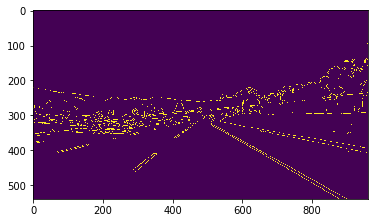

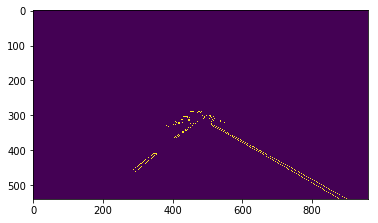

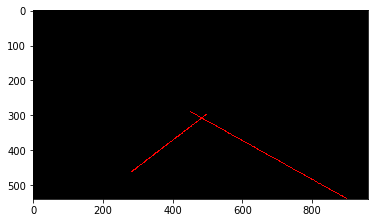

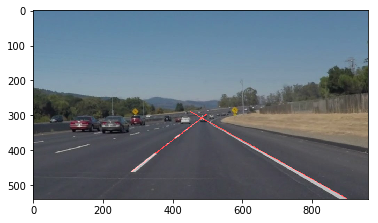

In [265]:
img_path = "test_images_1/" + images[0]
test_image = mpimg.imread(img_path)
#result1 = pipeline1(test_image, 100, 250, 3, 75, 125, 2) #baseline - not picking up left dashed line
#image, low_threshold, high_threshold, rho, threshold, min_line_length, max_line_gap
#result1 = pipeline1(test_image, 50, 150, 3, 20, 160, 60) # better - lane lines go too long and picking up additional
#result1 = pipeline1(test_image, 50, 90, 3, 20, 180, 100) # better - both lane lines
result1 = pipeline2(test_image, 50, 90, 3, 20, 175, 100) #best yet - next try to get
#plt.imshow(result1[0]) 
for ima in result1:
    plt.figure()
    plt.imshow(ima)

In [266]:
# from IPython.display import Image
# from IPython.display import display
# x = result[0]
# y = result[1] 
# display(x, y)

In [267]:
img_path = "test_images_1/" + images[5]
test_image = mpimg.imread(img_path)
result = pipeline(test_image)
plt.imshow(result[3]) 

NameError: name 'pipeline' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [268]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [269]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    all_images = pipeline2(image, 50, 90, 3, 20, 175, 100)
    result = all_images[3]
    return result

Let's try the one with the solid white lane on the right first ...

In [270]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.624548736462
0.600490196078
-0.726962457338
-0.754512635379
-0.754266211604
0.64768683274
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  4%|▍         | 9/222 [00:00<00:02, 86.10it/s]

0.624548736462
0.600490196078
-0.726962457338
-0.754512635379
-0.754266211604
0.64768683274
0.64907651715
-0.726368159204
0.5770609319
0.578595317726
-0.700460829493
-0.838565022422
-0.672811059908
0.507537688442
-0.724324324324
-0.840659340659
0.624624624625
-0.700879765396
0.599502487562
0.600638977636
-0.698224852071
-0.779467680608
-0.808580858086
0.604060913706
-0.80701754386
-0.698275862069
-0.781553398058
0.64907651715
0.577868852459
0.579545454545
-0.753086419753
-0.674157303371
-0.697142857143
0.673684210526
0.623115577889
0.600490196078
0.601466992665
-0.699481865285
0.600985221675
-0.725806451613
-0.72192513369
0.62457337884
0.600490196078
-0.752631578947
-0.725
0.6
-0.699074074074
-0.725888324873
-0.752631578947
0.600490196078
0.625
-0.675
-0.701298701299
-0.698689956332
0.601466992665
-0.756476683938
-0.727722772277
0.623409669211
0.59880239521
-0.7805907173
-0.752
-0.754098360656
-0.699633699634
0.60103626943
-0.701244813278
0.626598465473
0.6
-0.698324022346
-0.698863636

 12%|█▏        | 27/222 [00:00<00:02, 86.37it/s]

0.624365482234
0.649484536082
-0.702586206897
-0.675213675214
-0.703539823009
0.624040920716
0.649635036496
-0.701612903226
-0.698113207547
0.60396039604
0.671378091873
0.602076124567
-0.702857142857
0.650793650794
0.647668393782
-0.674876847291
-0.75
-0.699453551913
0.649214659686
0.625641025641
-0.725118483412
0.625
-0.698630136986
0.627777777778
-0.727748691099
0.625
0.625641025641
0.650969529086
-0.674329501916
-0.751322751323
-0.807106598985
-0.673469387755
0.575892857143
0.676229508197
-0.778801843318
0.625954198473
0.65306122449
-0.672077922078
-0.752212389381
-0.651063829787
-0.752727272727
0.624040920716
0.651162790698
-0.674220963173
-0.724770642202
0.649402390438
-0.722222222222
-0.724867724868
0.670050761421
0.625
-0.674496644295
-0.753424657534
-0.753246753247
0.652
-0.648936170213
0.623409669211
0.648936170213
0.625
0.621495327103
0.651090342679
0.622784810127
-0.721590909091
-0.721590909091
0.625316455696
0.649851632047
-0.725388601036
-0.700980392157
0.623737373737
0.64

 16%|█▌        | 36/222 [00:00<00:02, 85.43it/s]

0.625316455696
0.64907651715
0.64907651715
-0.673366834171
-0.778409090909
-0.674757281553
0.648044692737
-0.675
0.624365482234
0.648793565684
-0.725118483412
-0.697247706422
0.621722846442
-0.701834862385
0.648936170213
0.623409669211
0.622641509434
-0.67578125
-0.755555555556
-0.698795180723
-0.808411214953
-0.807106598985


 20%|█▉        | 44/222 [00:00<00:02, 82.24it/s]

0.648936170213
-0.750902527076
0.624678663239
-0.675675675676
-0.651428571429
0.622754491018
0.650717703349
-0.650717703349
0.624633431085
0.652777777778
-0.752380952381
0.623409669211
-0.699029126214
-0.676348547718
-0.780172413793
-0.672811059908
0.651583710407
0.645320197044
-0.751572327044
0.601265822785
-0.673469387755
-0.756097560976
-0.675213675214
-0.730964467005
0.652173913043
0.625316455696
-0.753164556962
0.625377643505
0.673139158576
0.625316455696
-0.7
0.624040920716
0.650176678445
-0.674757281553
-0.726804123711
-0.754010695187
-0.837988826816
0.67217630854
0.624338624339
-0.676724137931
0.6015625
-0.700440528634
-0.672340425532
0.673590504451
0.651063829787
-0.725118483412
-0.725099601594
-0.725388601036
0.673400673401
0.647058823529
-0.674285714286
0.648464163823
0.623737373737
0.671875
-0.697297297297
0.702702702703
-0.696335078534
0.673590504451
0.647058823529
-0.700934579439
-0.727272727273
0.647826086957
-0.652631578947
-0.699074074074


 23%|██▎       | 51/222 [00:00<00:02, 58.29it/s]

0.627027027027
0.600694444444
-0.699588477366
-0.725738396624
0.67
-0.699530516432
0.625531914894
-0.751879699248
0.672463768116
-0.724907063197
0.601941747573
-0.701754385965
-0.80737704918
0.629213483146
0.675749318801
0.625570776256
-0.753943217666
-0.674418604651
-0.675287356322
0.672661870504
-0.755555555556
-0.866666666667
-0.780373831776
0.647940074906
0.672086720867
-0.677192982456
0.624365482234
-0.780701754386
-0.808764940239
-0.7
0.600938967136
0.624338624339
0.673024523161
0.604395604396
0.600760456274
-0.724458204334
-0.699604743083
-0.701030927835
0.625
0.625316455696
0.673913043478
0.577777777778
-0.67032967033
-0.677777777778
0.580392156863
0.673295454545
0.625
-0.673267326733
-0.7
-0.807692307692
-0.698979591837
-0.724867724868


 26%|██▌       | 57/222 [00:00<00:03, 43.18it/s]

0.673024523161
0.626903553299
-0.724299065421
-0.698198198198
0.671875
-0.725961538462
-0.697777777778
0.650641025641
0.625
-0.674157303371
0.625498007968
-0.672862453532
-0.703125
0.625
0.650793650794
-0.648351648352
0.578680203046
0.624040920716
0.651428571429
-0.755208333333
0.651282051282
-0.724324324324
-0.648514851485
-0.705263157895
0.579487179487
0.624040920716
0.671732522796
-0.65
-0.727272727273
-0.65350877193
-0.75
-0.650224215247
0.624309392265
0.602649006623
-0.698795180723
-0.754464285714
-0.647509578544
0.673366834171
-0.650190114068
0.674033149171
-0.651851851852
0.646226415094
-0.726618705036
-0.673684210526
-0.725
0.673130193906
-0.675090252708
-0.650704225352
0.673076923077
0.648464163823
-0.726153846154
0.64953271028
-0.648888888889
-0.808411214953
0.674931129477
-0.756637168142
-0.650847457627
0.647368421053


 30%|███       | 67/222 [00:01<00:03, 42.68it/s]

0.673076923077
0.646687697161
-0.725631768953
-0.650704225352
0.647342995169
-0.65234375
-0.677824267782
0.674329501916
0.648514851485
0.7004048583
0.697749196141
0.558252427184
0.674931129477
0.648255813953
-0.702857142857
-0.648936170213
-0.645833333333
-0.677966101695
0.674528301887
0.673076923077
0.646766169154
-0.627906976744
-0.698979591837
-0.599118942731
0.675070028011
-0.702564102564
-0.648648648649
0.673130193906
0.646090534979
0.648293963255
-0.648760330579
-0.650205761317
-0.725118483412
-0.672413793103
0.673469387755
-0.696832579186
0.675749318801
0.647058823529
-0.671586715867
-0.674157303371
0.648083623693
-0.755020080321
0.673387096774
0.673024523161
0.648
0.647058823529
-0.676136363636
0.673076923077
0.67397260274
0.647272727273
-0.622009569378
-0.729281767956
0.648550724638
-0.647826086957
0.674863387978
0.67679558011
-0.721951219512
0.646788990826
-0.725490196078
0.648293963255
0.675
-0.648854961832
0.647668393782
-0.699588477366


 35%|███▍      | 77/222 [00:01<00:03, 42.74it/s]

-0.699152542373
0.674094707521
-0.622857142857
0.648293963255
0.67397260274
-0.649180327869
0.676282051282
-0.697142857143
-0.727272727273
-0.702247191011
0.647887323944
-0.650273224044
0.674931129477
-0.674528301887
-0.650568181818
-0.646511627907
-0.723502304147
0.647321428571
0.67397260274
-0.650137741047
-0.678947368421
-0.67027027027
0.649769585253
-0.674641148325
-0.626728110599
0.648
0.675675675676
-0.625698324022
-0.7
0.648148148148
-0.627777777778
0.652406417112
0.647519582245
0.676470588235
-0.647058823529
-0.672131147541
0.648936170213
0.649214659686
0.675
-0.697435897436
0.649068322981
-0.673267326733
-0.724719101124
0.699275362319
0.672727272727
-0.648068669528


 37%|███▋      | 82/222 [00:01<00:03, 44.45it/s]

-0.672489082969
-0.674033149171
0.698039215686
0.673003802281
-0.6
-0.697580645161
0.752336448598
-0.675799086758
0.699716713881
0.674329501916
0.678217821782
-0.645714285714
-0.650273224044
0.75
0.650655021834
0.625482625483
-0.625
-0.698412698413
0.700564971751
0.725225225225
0.699716713881

 39%|███▉      | 87/222 [00:01<00:02, 45.51it/s]


0.672782874618
-0.672727272727
-0.674311926606
-0.672897196262
0.669902912621
-0.6
-0.671232876712
0.651515151515
-0.646586345382
-0.674698795181
0.678571428571
-0.6484375
0.651474530831
-0.647368421053
0.725190839695
-0.672354948805
-0.671957671958
-0.650862068966
-0.626198083067
0.699716713881
-0.648876404494
0.673202614379
-0.672364672365
0.674107142857
-0.652406417112
0.697740112994
-0.650273224044
0.673913043478
-0.673295454545
0.671957671958
-0.64953271028
-0.625
0.699716713881
0.671826625387
-0.648044692737
-0.673913043478
-0.676258992806
0.671568627451
-0.700787401575
0.701704545455
0.673590504451
-0.673575129534
0.673170731707
-0.651515151515
-0.623115577889
-0.675531914894
0.701357466063


 41%|████▏     | 92/222 [00:01<00:02, 45.62it/s]

0.650793650794
-0.673267326733
-0.648648648649
0.579234972678
0.701754385965
-0.621359223301
-0.674418604651
0.649831649832
0.674757281553
-0.648936170213
0.575757575758
0.722772277228
0.673400673401
0.698863636364
0.673024523161
-0.673835125448
-0.699619771863
-0.673003802281
0.70297029703
-0.723502304147
-0.700757575758
0.672955974843
0.672131147541
0.701923076923
-0.622340425532
-0.647058823529
-0.701086956522
-0.698324022346
-0.675531914894
0.752212389381


 44%|████▎     | 97/222 [00:01<00:02, 46.40it/s]

0.7
0.672131147541
0.673913043478
-0.622009569378
-0.724489795918
-0.579545454545
0.701086956522
0.673590504451
-0.623931623932
-0.647826086957
0.672972972973
-0.647058823529
0.702702702703
-0.676
-0.673469387755
0.625
-0.629213483146
0.724738675958
-0.652027027027
0.698181818182
-0.674157303371
-0.645833333333
-0.698795180723
-0.677042801556
0.725085910653
0.696832579186
-0.649717514124
-0.674876847291
-0.727272727273
-0.672985781991
0.726114649682
-0.723618090452
-0.700892857143
-0.675141242938
0.7
0.699570815451
-0.648199445983
0.752136752137
-0.647321428571
-0.699669966997
0.723723723724

 46%|████▌     | 102/222 [00:01<00:02, 47.15it/s]


0.698529411765
0.725490196078
-0.674626865672
-0.625698324022
-0.674242424242
-0.622857142857
0.674931129477
0.700534759358
-0.674157303371
-0.701086956522
0.725308641975
-0.646739130435
-0.622857142857
0.701986754967
0.699507389163
-0.650485436893
-0.676767676768
-0.673366834171
-0.648351648352
0.702005730659
0.673024523161
0.675824175824
-0.651063829787
-0.674107142857
-0.699115044248
-0.627802690583
0.700854700855
0.674863387978
0.702564102564
-0.622857142857


 48%|████▊     | 107/222 [00:02<00:02, 47.05it/s]

-0.672566371681
0.700980392157
0.672316384181
-0.670454545455
0.673780487805
-0.621052631579
0.672086720867
0.698591549296
-0.64824120603
-0.64824120603
-0.754189944134
0.671698113208
0.674796747967
0.701408450704
0.700564971751
-0.723756906077
-0.752475247525
0.650918635171
0.752808988764
-0.649606299213
-0.752212389381
0.754646840149
0.748717948718
-0.724867724868
0.700564971751
-0.722826086957
0.673400673401
0.700564971751
-0.649659863946
-0.650602409639
-0.751219512195
-0.727272727273
0.674897119342
0.674796747967
0.699716713881
-0.648571428571
-0.72641509434
-0.779816513761
-0.702564102564
-0.6996996997
-0.755555555556


 50%|█████     | 112/222 [00:02<00:02, 46.90it/s]

0.725738396624
-0.649305555556
0.752650176678
0.649546827795
-0.726618705036
-0.725490196078
0.651041666667
-0.67264573991
0.726141078838
0.649867374005
-0.700296735905
-0.671428571429
0.649484536082
-0.725631768953
0.699716713881
0.673529411765
-0.650273224044
0.700564971751
-0.672316384181
0.698591549296
0.67
-0.673366834171
-0.676616915423
0.7


 53%|█████▎    | 117/222 [00:02<00:02, 47.22it/s]

0.650557620818
-0.700460829493
0.675531914894
0.651041666667
-0.779411764706
-0.806451612903
-0.670157068063
0.698591549296
0.672535211268
-0.699588477366
-0.651376146789
0.700288184438
0.605
0.649214659686
0.674329501916
0.650557620818
-0.649717514124
-0.647727272727
0.675276752768
0.649390243902
-0.671957671958
-0.647668393782
0.698564593301


 55%|█████▍    | 122/222 [00:02<00:02, 42.78it/s]

0.675
0.650666666667
-0.672985781991
0.647519582245
-0.649289099526
0.674418604651
0.626506024096
-0.626016260163
-0.698275862069
0.65
0.674863387978
-0.699551569507
0.647272727273
0.626198083067
0.628571428571
0.674931129477
-0.700389105058
0.67397260274
-0.65
-0.673076923077
-0.65296803653
0.646288209607
-0.700315457413
0.627027027027
0.674863387978
-0.648967551622
-0.626666666667
-0.700934579439
0.67397260274
0.626984126984


 58%|█████▊    | 128/222 [00:02<00:02, 44.91it/s]

0.674863387978
-0.702702702703
0.648387096774
-0.647222222222
-0.62582781457
-0.628440366972
-0.724719101124
0.672131147541
-0.649025069638
0.600694444444
-0.725352112676
0.604651162791
-0.7004048583
0.624365482234
0.675749318801
-0.649717514124
0.65034965035
0.623737373737
-0.698412698413
-0.726775956284
-0.671875
0.623737373737
0.650793650794
-0.674107142857
-0.676328502415
0.626506024096
-0.675675675676
-0.651741293532
0.625
0.65
0.620879120879
-0.674509803922
-0.698412698413
0.626373626374
0.650485436893
-0.724576271186
-0.725321888412
-0.783068783069
0.648293963255
0.623737373737
0.625592417062
0.624309392265
0.65
0.626598465473
-0.649214659686
-0.675675675676
0.64907651715
-0.730337078652
0.622282608696
0.65
-0.67619047619
0.648293963255
-0.748663101604
-0.752631578947
0.622395833333
0.64907651715
-0.754189944134
-0.672199170124
-0.778378378378
-0.69696969697
-0.75117370892
-0.753926701571
0.672566371681
0.622149837134
-0.672727272727
-0.676363636364


 60%|██████    | 134/222 [00:02<00:01, 46.29it/s]

0.649214659686
-0.725806451613
0.623409669211
-0.672727272727
-0.751700680272
0.624293785311
0.625654450262
0.647368421053
-0.72380952381
-0.7
-0.650537634409
-0.780575539568
0.625615763547
0.624365482234
-0.651260504202
-0.676923076923
-0.754545454545
0.624020887728
0.65
-0.675213675214
0.650969529086
-0.751677852349
-0.751968503937
0.603703703704
0.671641791045
0.62599469496
-0.672316384181
0.649484536082
0.624352331606
0.648648648649
-0.752747252747
0.648351648352
-0.755681818182


 63%|██████▎   | 139/222 [00:02<00:01, 46.25it/s]

0.650406504065
0.623052959502
-0.725490196078
-0.703196347032
-0.725961538462
-0.727777777778
-0.677595628415
-0.753768844221
0.6484375
0.622857142857
-0.676
-0.726495726496
0.625698324022
-0.728070175439
0.623728813559
-0.7
0.623145400593
0.649484536082
0.625
0.623115577889
0.650485436893
-0.702702702703
-0.72625698324
-0.673796791444
0.647727272727
-0.72625698324
0.622159090909

 65%|██████▍   | 144/222 [00:02<00:01, 45.26it/s]


0.626373626374
-0.675531914894
-0.78021978022
-0.65
0.153846153846
-0.626373626374
-0.752688172043
0.621875
-0.678217821782
0.649732620321
-0.75
0.622784810127
0.62467191601
-0.654054054054
0.65
-0.725190839695
0.624685138539
0.623737373737
-0.698529411765
-0.727272727273
-0.674033149171
-0.677570093458
-0.757894736842
0.624060150376
0.649214659686
-0.700934579439
-0.726688102894
-0.777292576419
0.652849740933
0.649484536082
0.623003194888
-0.698630136986
0.64907651715
0.65
-0.779591836735
-0.701244813278
-0.673913043478


 67%|██████▋   | 149/222 [00:02<00:01, 43.47it/s]

0.601108033241
0.671586715867
-0.699404761905
-0.731428571429
-0.674846625767
0.672316384181
-0.75572519084
0.6
0.674242424242
0.578274760383
0.601466992665
0.646825396825
-0.698979591837
-0.754098360656
0.601123595506
0.626373626374
0.578616352201
-0.701357466063
-0.725490196078
-0.674008810573
-0.724867724868
-0.726829268293
-0.700534759358


 69%|██████▉   | 154/222 [00:03<00:01, 44.33it/s]

0.6484375
0.646408839779
-0.723404255319
-0.723981900452
0.580487804878
0.697247706422
0.647540983607
-0.754545454545
-0.696335078534
0.579487179487
-0.72850678733
-0.698795180723
0.647540983607
0.622149837134
0.625
0.647849462366
0.623563218391
-0.7
0.621513944223
-0.651685393258
0.601503759398
0.581632653061
-0.701492537313
-0.726829268293
0.603260869565
0.626315789474
-0.673366834171
0.648501362398
0.624584717608
-0.700421940928
0.649456521739
-0.724890829694
-0.650485436893
-0.751196172249


 72%|███████▏  | 159/222 [00:03<00:01, 43.67it/s]

0.600619195046
0.625592417062
-0.752
-0.725490196078
0.672932330827
-0.755020080321
0.724299065421
-0.726872246696
-0.7265917603
0.623376623377
0.625396825397
0.602230483271
-0.778801843318
0.577287066246
-0.698757763975
-0.807692307692
-0.702830188679
-0.673684210526
0.60162601626
-0.756906077348
-0.753424657534
0.60097323601
0.625396825397
-0.751322751323
-0.725
-0.70202020202
-0.80790960452
0.626168224299
0.600508905852
0.623737373737
-0.754777070064
-0.726993865031
-0.753303964758
-0.726851851852
-0.72864321608


 74%|███████▍  | 164/222 [00:03<00:01, 43.83it/s]

0.625316455696
0.599221789883
0.622784810127
0.597345132743
-0.698924731183
0.445714285714
0.598253275109
-0.728260869565
-0.780172413793
-0.725806451613
0.601449275362
0.578397212544
-0.752650176678
-0.78021978022
0.576923076923
-0.756756756757
0.602739726027
0.624338624339
0.5546875
-0.754464285714
0.55614973262
-0.778301886792
-0.751196172249
0.603921568627
0.578199052133
0.577464788732
0.600917431193


 76%|███████▌  | 169/222 [00:03<00:01, 44.56it/s]

0.600490196078
0.576744186047
0.578431372549
0.623711340206
0.577830188679
0.600558659218
0.576744186047
-0.700507614213
-0.807486631016
0.60097323601
0.598039215686
0.577142857143
0.601049868766
-0.781553398058
-0.810810810811
0.576744186047
-0.724770642202
0.601941747573
-0.725490196078
-0.78431372549
0.577272727273
0.599514563107
0.597222222222
-0.754098360656
-0.778242677824
0.579439252336
-0.7805907173
-0.754545454545
0.599514563107


 78%|███████▊  | 174/222 [00:03<00:01, 43.90it/s]

0.576470588235
0.576923076923
-0.811111111111
-0.727891156463
0.622222222222
-0.839572192513
-0.780918727915
-0.703703703704
0.577726218097
-0.809352517986
0.600484261501
0.600484261501
-0.727891156463
-0.837837837838
-0.756272401434
-0.806629834254
-0.83908045977
0.576470588235
0.600484261501
0.600746268657
-0.807560137457
-0.723549488055
0.510101010101
-0.77990430622
0.600985221675
0.6
0.572815533981
0.556179775281
0.648648648649
0.553935860058
-0.806896551724
0.577464788732
0.60101010101
0.598540145985
-0.724279835391
0.577102803738
0.6
-0.784946236559
-0.783783783784
0.599514563107
-0.812154696133
0.598253275109


 81%|████████  | 179/222 [00:03<00:00, 44.62it/s]

0.575757575758
0.622340425532
-0.780373831776
-0.781990521327
0.646511627907
-0.811881188119
-0.808988764045
0.575221238938
0.602409638554
-0.751937984496
-0.752895752896
-0.781746031746
0.601694915254
0.577358490566
-0.780821917808
0.601466992665
0.578454332553
0.603921568627
0.577102803738
0.601503759398
-0.784090909091


 83%|████████▎ | 184/222 [00:03<00:00, 45.16it/s]

0.576744186047
0.601731601732
0.578088578089
-0.755980861244
-0.840425531915
-0.84126984127
0.604444444444
0.577726218097
-0.754098360656
-0.866666666667
0.752525252525
-0.701298701299
0.778947368421
0.600484261501
0.598326359833
-0.867021276596
-0.782608695652
0.602040816327
-0.897321428571
-0.754325259516
0.578680203046
0.623287671233
-0.808743169399
0.6
-0.778947368421
-0.867521367521
-0.752688172043
-0.840659340659
0.576744186047
0.577142857143
-0.753521126761
-0.839857651246
0.601851851852
-0.837455830389
0.578680203046
-0.781990521327
0.576388888889
-0.839130434783
0.575406032483
0.602678571429
0.579207920792
-0.839215686275
-0.751037344398
-0.753943217666
-0.754464285714
-0.751655629139
-0.725714285714
0.57881773399
0.578358208955
0.602150537634
0.580952380952
0.622073578595
0.578666666667
0.578947368421
0.601226993865
-0.756476683938
-0.780748663102
-0.811111111111
-0.755102040816
0.555555555556
0.622950819672
-0.754545454545
-0.752252252252
-0.779342723005
0.55601659751
0.6228

 87%|████████▋ | 194/222 [00:03<00:00, 44.99it/s]

-0.808333333333
0.60101010101
-0.837719298246
0.575396825397
0.599033816425
0.574923547401
0.6
-0.754166666667
-0.755244755245
-0.72619047619
0.555555555556
0.597989949749
0.621495327103
0.647826086957
0.555819477435
0.580808080808
-0.75
-0.779411764706
0.465909090909
-0.838709677419
0.672222222222
-0.805128205128
0.598101265823
0.575
-0.753138075314
-0.808888888889
0.574162679426
-0.75641025641
0.576131687243
0.575197889182
-0.752650176678
0.579591836735
-0.837719298246
0.579234972678
-0.839357429719
0.60097323601
0.599514563107
0.574007220217
-0.812030075188
-0.728682170543
-0.838056680162
-0.748571428571


 90%|████████▉ | 199/222 [00:04<00:00, 45.36it/s]

0.577205882353
0.6
-0.754901960784
-0.809027777778
0.597883597884
-0.727272727273
-0.842105263158
0.577669902913
0.60097323601
0.577464788732
-0.838129496403
0.554347826087
0.554945054945
0.597744360902
0.577586206897
0.576388888889
0.599514563107
-0.752577319588
-0.755208333333
-0.811224489796
0.600985221675
-0.867403314917


 92%|█████████▏| 204/222 [00:04<00:00, 43.51it/s]

0.601941747573
0.556818181818
0.576923076923
0.6
-0.809756097561
-0.840425531915
-0.807511737089
0.64606741573
0.59765625
0.555555555556
0.578571428571
0.553846153846
-0.867521367521
-1.0
0.532567049808
-0.780373831776
-1.27586206897
0.600484261501
0.55701754386
0.48743718593
0.59756097561
0.6
0.572972972973
-0.75
-0.751351351351
0.554404145078
0.59765625
-0.727272727273
0.554585152838
0.575645756458
-0.836842105263
-0.811224489796
-0.805263157895
-0.838541666667
0.555555555556
-0.755186721992
0.579646017699
-0.836363636364
-0.838709677419
-0.841628959276
0.554545454545
0.57928802589
-0.778571428571
-0.836206896552
-0.836633663366
0.553072625698
-0.807881773399
-0.865
-0.753968253968
0.596590909091
0.554666666667
0.55737704918
-0.836206896552
-0.724489795918
0.554112554113
-0.866972477064
-0.753164556962
-0.869109947644
0.57967032967
0.553956834532
-0.779935275081
-0.837301587302
0.557251908397
0.554502369668
-0.869565217391
-0.782407407407
0.579185520362


 94%|█████████▍| 209/222 [00:04<00:00, 43.99it/s]

0.576744186047
0.555808656036
-0.84188034188
-0.810344827586
-0.899159663866
0.555555555556
0.553884711779
0.577114427861
0.555035128806
0.553738317757
-0.839160839161
0.57855361596
0.553990610329
-0.807692307692
-0.780748663102
0.552542372881
-0.78125
0.552631578947
0.555555555556
-0.805825242718
-0.780952380952
-0.781395348837
-0.781914893617
-0.755208333333
0.553956834532
0.577726218097
0.57800511509
-0.782101167315
-0.837606837607
-0.780876494024
-0.808988764045
0.576923076923
0.553571428571
0.554272517321


 97%|█████████▋| 215/222 [00:04<00:00, 46.10it/s]

0.578406169666
0.554565701559
0.553571428571
-0.808988764045
-0.729281767956
0.553571428571
0.575757575758
-0.837696335079
-0.753488372093
-0.700564971751
0.5548098434
0.57729468599
-0.808510638298
-0.728971962617
-0.781512605042
0.57800511509
-0.84
0.5548098434
0.577215189873
-0.778894472362
-0.835748792271
-0.834196891192
-0.729468599034
0.55497382199


100%|█████████▉| 221/222 [00:04<00:00, 47.95it/s]

0.554272517321
0.576923076923
-0.777777777778
-0.811594202899
-0.80829015544
-0.811518324607
0.577540106952
-0.811403508772
-0.811518324607
-0.757575757576
0.577777777778
0.555825242718
-0.812227074236
-0.726688102894
-0.809688581315
-0.838827838828
-0.755020080321
-0.753846153846
0.57793764988
0.554022988506
-0.839160839161
0.578723404255


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.06 s, sys: 1.06 s, total: 4.13 s
Wall time: 5.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [271]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [272]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.628
-0.602272727273
0.673400673401
-0.60152284264
0.698630136986
-0.626213592233
0.698924731183
0.698412698413
0.754189944134
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|▏         | 9/682 [00:00<00:07, 84.21it/s]

-0.628
-0.602272727273
0.673400673401
-0.60152284264
0.698630136986
-0.626213592233
0.698924731183
0.698412698413
0.754189944134
-0.627009646302
0.673130193906
-0.60253164557
0.698550724638
-0.602094240838
0.648501362398
0.72619047619
0.651026392962
-0.647887323944
0.672597864769
-0.621145374449
0.679144385027
0.650918635171
-0.674033149171
0.647302904564
0.727941176471
0.725490196078
-0.649456521739
-0.648501362398
-0.620512820513
0.723602484472
-0.644444444444
0.648351648352
0.650273224044
-0.622489959839
-0.625
-0.648648648649
0.700534759358
0.700534759358
-0.625
-0.290502793296
0.723756906077
0.678756476684
-0.62467191601
-0.651452282158
0.648148148148
0.754646840149
0.622807017544
0.727941176471
0.7
0.62389380531
-0.62467191601
-0.650273224044
0.673640167364
0.670886075949
0.728125
0.70351758794
-0.650224215247
-0.625974025974
0.675824175824
-0.625
-0.651090342679
0.647272727273
0.700440528634
-0.625
-0.648760330579
0.69921875
-0.725806451613
-0.601063829787
0.725714285714
-0.6507

  4%|▍         | 26/682 [00:00<00:08, 80.70it/s]

-0.699421965318
-0.7
-0.647940074906
0.674876847291
0.674757281553
0.649038461538
-0.781609195402
-0.674757281553
-0.650793650794
-0.69970845481
-0.649350649351
0.755434782609
0.6
0.725274725275
0.598360655738
0.672043010753
-0.673130193906
-0.69970845481
0.699588477366
0.580310880829
-0.673469387755
0.699588477366
-0.674033149171
-0.700581395349
0.675595238095
0.650537634409
-0.700581395349
0.701863354037
0.644808743169
-0.67217630854
-0.700460829493
0.648514851485
-0.674008810573
0.646766169154
0.623595505618
-0.699421965318
-0.673130193906
0.620689655172
0.652380952381
-0.624365482234
-0.699421965318
-0.672727272727
0.624521072797
0.650602409639
-0.724696356275
-0.67323943662
0.625850340136
0.701421800948
-0.750972762646
0.648936170213
-0.726368159204
0.64768683274
-0.723214285714
0.625368731563
-0.698924731183
0.625
0.724279835391
0.601851851852
0.675572519084
-0.648780487805
-0.698324022346
-0.674094707521
-0.700581395349
0.650130548303
0.623978201635
-0.674094707521
0.62413793103

  6%|▋         | 44/682 [00:00<00:07, 82.61it/s]

-0.752688172043
-0.7
0.647058823529
0.626262626263
0.625
-0.697080291971
-0.805555555556
0.702247191011
-0.809090909091
0.623853211009
-0.751879699248
0.625
0.623255813953
0.622727272727
-0.726457399103
-0.750902527076
0.673469387755
0.650485436893
0.67032967033
-0.727777777778
-0.724907063197
-0.754285714286
0.600706713781
0.697142857143
0.58041958042
0.676855895197
0.648888888889
0.649402390438
0.628415300546
-0.753125
-0.700288184438
0.598130841121
0.624595469256
0.64824120603
0.623376623377
0.675675675676
-0.701149425287
0.648414985591
-0.753846153846
0.580769230769
0.673076923077
0.578125
-0.726872246696
-0.778894472362
0.648484848485
0.649425287356
-0.779569892473
0.577777777778
-0.699140401146
-0.80829015544
0.623409669211
0.601092896175
-0.726618705036
0.602209944751
-0.627027027027
0.649230769231
-0.723484848485
-0.728395061728
0.622448979592
-0.868932038835
-0.809128630705
0.6
0.601990049751
-0.72641509434
-0.757085020243
-0.75
-0.699140401146
-0.839357429719
-0.725903614458


  7%|▋         | 51/682 [00:00<00:09, 66.88it/s]


-0.723300970874
0.6
-0.726235741445
-0.754601226994
0.601503759398
0.624505928854
-0.726851851852
0.600790513834
0.6
-0.753488372093
-0.725738396624
-0.780487804878
0.648305084746
0.578231292517
0.672985781991
0.574675324675
0.648351648352
0.625
-0.754601226994
-0.725694444444
0.600591715976
-0.754601226994
0.625
0.600682593857
-0.7
-0.702586206897
0.600496277916
0.622784810127
-0.675889328063
0.675
-0.697777777778
0.601173020528
0.627777777778
-0.698863636364
0.6472303207
-0.728205128205
0.576227390181
-0.699140401146
0.65
-0.700288184438
0.577114427861
-0.809523809524
0.622222222222
0.651933701657
-0.809278350515
0.577114427861
0.59693877551
-0.700996677741
-0.701587301587
-0.730769230769
0.624390243902
0.649484536082
-0.700787401575
0.649746192893
-0.701298701299
-0.700288184438
-0.778242677824
-0.653631284916
0.625
-0.871595330739
0.598290598291
-0.725165562914
-0.753799392097
-0.72268907563
0.673529411765
0.647564469914
0.623036649215
0.671568627451


  9%|▊         | 58/682 [00:00<00:10, 60.25it/s]

-0.700964630225
-0.728723404255
0.648351648352
-0.726457399103
0.650666666667
0.64606741573
0.696808510638
0.647727272727
0.674418604651


  9%|▉         | 64/682 [00:00<00:10, 59.11it/s]

-0.701257861635
-0.753571428571
0.624365482234
0.624365482234
-0.777173913043
-0.700854700855
-0.726907630522
0.67032967033
0.650485436893
0.598253275109
0.698757763975
0.697916666667
-0.652173913043
0.648199445983
-0.698275862069
-0.727272727273
0.675070028011
0.578125
0.675675675676
0.648571428571
0.624338624339
-0.751748251748
-0.676012461059
0.649025069638
0.625468164794
-0.808743169399
0.647840531561
-0.867403314917
-0.727586206897
0.675675675676
-0.724035608309
-0.724489795918
0.600638977636
-0.698305084746
0.6
0.622950819672
-0.727891156463
0.650519031142
-1.03351955307
-0.725663716814
0.623563218391
-0.7
0.62331838565
0.553488372093
0.577777777778
-0.700534759358
-0.778242677824
0.648351648352
-0.726872246696
0.698564593301
-0.725903614458
0.600985221675
0.625641025641
-0.699248120301
0.623655913978
0.673913043478
0.6
-0.727598566308
-0.697368421053
0.625899280576
0.649214659686
0.577319587629
0.602150537634
-0.727002967359
-0.698412698413
0.649214659686
0.625
0.59900990099
0.5

 10%|█         | 70/682 [00:01<00:10, 57.99it/s]

-0.727810650888
-0.7
0.675900277008
0.672199170124
0.674351585014
-0.724137931034
0.6


 11%|█         | 76/682 [00:01<00:10, 57.31it/s]

-0.675
-0.753676470588
0.649122807018
0.649171270718
-0.702325581395
0.575757575758
-0.652542372881
0.578680203046
-0.727272727273
-0.751851851852
-0.752747252747
0.599033816425
-0.649446494465
0.696132596685
0.7
0.602870813397
-0.674157303371
-0.750902527076
0.621145374449
0.649769585253
0.648401826484
0.648148148148
-0.964757709251
0.647727272727
-0.675105485232
0.625
-0.675
0.623481781377
-0.701492537313
-0.782122905028
0.696078431373
-0.675
0.7
-0.778409090909
0.601593625498
0.647058823529
0.603174603175
-0.697211155378
-0.698830409357
0.621908127208
-0.751269035533
0.674329501916
0.649056603774
-0.698113207547
0.67094017094
-0.752808988764
0.601796407186
-0.651515151515
-0.652777777778
0.674418604651
0.671641791045
0.624390243902
0.646153846154
-0.811428571429
0.648387096774
0.58
0.672
0.649484536082
0.625329815303
-0.674094707521
-0.675496688742
-0.700729927007
-0.84
0.625
-0.897435897436
0.602040816327
-0.838709677419
-0.930131004367
0.622222222222
-0.675824175824
-0.65405405405

 12%|█▏        | 83/682 [00:01<00:10, 58.88it/s]


-0.698412698413
0.649122807018
0.649350649351
-0.726443768997
-0.698795180723
0.673469387755
0.648221343874
0.674107142857
0.72602739726


 13%|█▎        | 90/682 [00:01<00:09, 59.84it/s]

-0.72754491018
-0.674033149171
0.622340425532
-0.675
0.649122807018
0.675
-0.723404255319
0.698412698413
-0.697247706422
0.701570680628
-0.751879699248
0.577464788732
-0.727611940299
-0.679144385027
-0.674931129477
-0.75
0.671361502347
0.645739910314
-0.699453551913
-0.677725118483
0.697115384615
-0.675070028011
-0.704035874439
0.623015873016
0.675105485232
-0.701960784314
0.626459143969
0.603174603175
-0.672131147541
-0.675977653631
-0.701538461538
0.624561403509
-0.701923076923
0.6015625
0.698347107438
-0.696832579186
0.725118483412
0.698412698413
0.7
0.650862068966
-0.700288184438
-0.674094707521
0.623493975904
0.646875
0.649230769231
0.624242424242
-0.675977653631
0.622739018088
-0.700288184438
0.649214659686
-0.69970845481
0.649350649351
-0.671936758893
0.649867374005
0.647058823529
-0.698275862069
0.623076923077
0.649867374005
-0.675141242938
-0.673400673401
0.623574144487
0.64953271028
0.672297297297
-0.703883495146
0.673366834171
0.696335078534
-0.676056338028
-0.699421965318
0

 15%|█▍        | 102/682 [00:01<00:10, 55.63it/s]

-0.701754385965
0.648148148148
-0.698275862069
-0.36
0.649253731343
-0.839160839161
0.649056603774
-0.675287356322
-0.698830409357
0.624365482234
-0.703539823009
-0.672354948805
0.645502645503
0.624338624339
-0.675213675214
-0.700879765396
0.648780487805
0.67027027027
-0.674033149171
0.650246305419
0.649484536082
-0.674267100977
-0.701298701299
0.648401826484
0.699507389163
-0.700787401575
0.671428571429
-0.673184357542
0.698324022346
0.6
-0.676012461059
0.621513944223
-0.702702702703
0.647540983607
-0.365714285714
0.623015873016
-0.698564593301
0.699507389163
-0.673835125448
-0.676136363636
0.648936170213
-0.70202020202
-0.702797202797
0.698347107438
0.698863636364
0.627450980392
-0.674220963173
-0.700787401575
0.647249190939
0.645631067961
-0.69970845481
0.649746192893
-0.671586715867
0.674285714286
-0.700581395349
0.646226415094
0.672932330827
-0.811224489796
0.700507614213
-0.700534759358
0.645833333333
0.602230483271
0.6
-0.674220963173
-0.702702702703
0.674033149171
0.60152284264

 17%|█▋        | 114/682 [00:01<00:10, 52.67it/s]

-0.702312138728
-0.675141242938
0.622807017544
0.601694915254
-0.625
0.6
-0.698224852071
-0.673076923077
0.651639344262
-0.701449275362
0.577358490566
-0.308571428571
0.627118644068
0.647773279352
0.675531914894
-0.671641791045
-0.700581395349
0.602040816327
0.623655913978
-0.701754385965
-0.672897196262
0.672316384181
-0.67264573991
0.648351648352
-0.809734513274
0.601941747573
0.60101010101
-0.699115044248
-0.673306772908
-0.673469387755
0.673267326733
0.673469387755
0.673469387755
-0.726872246696
-0.672268907563
0.621848739496
0.648902821317
0.605405405405
0.600877192982
0.624309392265
0.622222222222
-0.72380952381
-0.696517412935
0.623134328358
0.650602409639
0.673640167364
-0.781094527363
0.670995670996
0.625468164794
-0.75117370892
0.625
-0.701492537313
0.648275862069
-0.674418604651
-0.675900277008
0.648967551622
0.624584717608
0.624641833811
-0.700598802395
-0.698492462312
0.622222222222
0.647651006711
-0.701657458564
-0.559322033898
-0.675531914894
0.62331838565
0.623655913978

 18%|█▊        | 126/682 [00:02<00:10, 51.72it/s]

-0.724137931034
-0.675287356322
0.624020887728
0.648293963255
0.647940074906
0.65
-0.673590504451
0.645454545455
-0.727272727273
-0.674351585014
0.672222222222
0.599033816425
0.623762376238
0.646153846154
-0.674033149171
-0.675392670157
0.59900990099
-0.701492537313
-0.674033149171
0.649289099526
0.673469387755
0.626168224299
0.597285067873
0.601895734597
-0.674208144796
-0.674033149171
-0.70351758794
-0.675213675214
0.598393574297
0.600806451613
0.697115384615
0.648068669528
-0.675
-0.6996996997
0.623574144487
-0.673130193906
0.6
0.625468164794
-0.675
-0.725
0.625
0.648464163823
0.622448979592
0.625
0.622448979592
-0.675824175824
-0.728125
0.646153846154
0.675531914894
-0.675675675676
0.651960784314
0.650246305419
-0.677777777778
-0.72602739726
0.673076923077
0.600840336134
0.646017699115
0.650717703349
0.672222222222
0.651428571429
-0.727272727273
-0.72619047619
-0.697841726619
0.672316384181
0.65
0.697777777778
0.72864321608
0.7
-0.726235741445
-0.72641509434
-0.697674418605
0.62545

 20%|██        | 138/682 [00:02<00:10, 53.93it/s]


-0.752808988764
0.600522193211
0.67094017094
0.579831932773
-0.868571428571
0.673575129534
-0.754010695187
-0.725274725275
-0.675977653631
0.600985221675
-0.72619047619
0.674242424242
-0.728758169935
0.646511627907
-0.676870748299
-0.70202020202
-0.701342281879
0.598984771574
0.578680203046
0.645714285714
-0.677419354839
-0.651515151515
0.601895734597
-0.623036649215
-0.899159663866
0.599056603774
0.623711340206
-0.672268907563
-0.72619047619
-0.725903614458
0.649038461538
0.649769585253
0.647619047619
-0.676880222841
-0.724489795918
0.598455598456
0.674008810573
0.534391534392
0.600775193798
-0.726872246696
-0.752136752137
-0.65
-0.780876494024
0.648148148148
-0.305555555556
0.599303135889
-0.723404255319
0.67264573991
-0.727272727273
0.673366834171
-0.673003802281
0.6
-0.674157303371
0.602941176471
-0.75
-0.752808988764
0.6
0.623115577889
-0.78125
-0.673410404624
-0.700980392157
0.671794871795
-0.75
0.64824120603
0.65
0.673469387755
0.620879120879
-0.724770642202
-0.696581196581
-0.

 21%|██        | 144/682 [00:02<00:10, 51.90it/s]

-0.72619047619
-0.696517412935
0.622807017544
-0.725563909774
0.647416413374
0.600840336134
-0.676056338028
0.600985221675
-0.724242424242
0.646288209607
-0.726923076923
-0.285714285714
-0.806818181818
-0.677595628415
-0.651452282158
0.598522167488
-0.701067615658
-0.65
0.648648648649
0.533980582524
-0.703296703297
-0.648780487805
-0.726984126984
-0.675126903553
0.598039215686
-0.724458204334
0.648351648352
-0.305555555556
-0.675824175824
-0.675824175824
-0.724919093851
0.600961538462
-0.724550898204
-0.307692307692
0.600961538462
0.622549019608
0.64824120603
-0.678217821782
-0.72754491018
0.578313253012
-0.270718232044
0.675392670157
0.674157303371
-0.725806451613
-0.725373134328
-0.698630136986
0.578378378378
-0.070652173913
-0.268421052632
0.67264573991
-0.674157303371
-0.703910614525
0.648936170213
-0.342857142857
-0.698630136986
0.651685393258
-0.675925925926
-0.725373134328
-0.698347107438
0.597989949749
0.624390243902
-0.725552050473
-0.675925925926
-0.704301075269
0.67487684729

 22%|██▏       | 150/682 [00:02<00:09, 53.57it/s]

0.727272727273
-0.674496644295
-0.702857142857
0.624087591241
-0.701086956522
0.624535315985
-0.601990049751
0.701244813278
0.603053435115


 23%|██▎       | 156/682 [00:02<00:09, 52.63it/s]

-0.675070028011
0.623115577889
-0.702247191011
0.623762376238
-0.699115044248
0.623115577889
0.646464646465
-0.306878306878
0.623417721519
0.648876404494
-0.674486803519
0.621621621622
-0.701195219124
-0.652671755725
0.62443438914
-0.70297029703
-0.753289473684
-0.651877133106
0.648501362398
0.575757575758
-0.809278350515
-0.32967032967
-0.651041666667
0.673076923077
-0.724919093851
0.6015625
-0.287958115183
-0.841584158416
0.601123595506
-0.726072607261
-0.698795180723
0.621468926554
0.601092896175
0.673913043478
-0.342696629213
0.577889447236
-0.90099009901
-0.674157303371
-0.700440528634
0.621761658031
0.647368421053
-0.343915343915
0.601990049751
0.649214659686
-0.778169014085
0.579439252336
-0.965065502183
-1.0
-0.72625698324
-0.674157303371
-0.700819672131
-0.341584158416
0.577405857741
0.598290598291
-0.676348547718
-0.698795180723
-0.230769230769
-0.725165562914
-0.697959183673
0.624624624625
-0.342857142857
-0.118644067797
0.601694915254
-0.072625698324
-0.698863636364
0.57794

 24%|██▍       | 162/682 [00:02<00:09, 53.52it/s]

-0.674496644295
-0.700440528634
-0.324175824176
0.576470588235
0.575875486381
0.645739910314
-0.697802197802


 25%|██▍       | 168/682 [00:02<00:09, 52.87it/s]

-0.676991150442
0.625
-0.701195219124
0.59925093633
-0.700564971751
-0.36018957346
-0.648888888889
-0.232227488152
0.600806451613
-0.697777777778
0.59872611465
-0.727272727273
0.625360230548
0.601973684211
-0.726993865031
-0.344660194175
0.622807017544
-0.697318007663
-0.700757575758
-0.702702702703
0.55497382199
-0.344827586207
-0.698324022346
0.531914893617
0.671875
0.554285714286
0.620689655172
0.601990049751
0.575178997613
-0.697841726619
-0.725609756098
-0.338983050847
0.625
-0.404494382022
-0.267015706806
-0.698924731183
0.553278688525
-0.699530516432
0.577565632458
-0.702127659574
-0.651515151515
0.624324324324
-0.344444444444
0.576530612245
-0.72625698324
0.648305084746
-0.700325732899
-0.726443768997
0.601941747573
0.621052631579
-0.286384976526
0.650537634409
-0.69696969697
0.575471698113
-0.724770642202
-0.142857142857
0.57619047619
-0.701449275362
-0.7
-0.724770642202
0.55230125523
0.573913043478
-0.401129943503
0.673469387755
-0.7265625
-0.700581395349
0.577075098814
0.575

 26%|██▋       | 180/682 [00:03<00:09, 51.13it/s]

-0.753125
-0.723214285714
0.532567049808
-0.363636363636
0.623853211009
-0.810810810811
0.553299492386
-0.753289473684
-0.7265625
0.599206349206
0.576923076923
-0.443349753695
0.553990610329
-0.725085910653
0.6
0.579124579125
-0.753943217666
-0.755319148936
0.529824561404
-0.724637681159
-0.753164556962
0.6
0.553424657534
-0.36
-0.755434782609
0.552407932011
-0.728070175439
0.554524361949
-0.779026217228
0.622807017544
-0.726726726727
0.622641509434
-0.360824742268
0.55421686747
0.534246575342
-0.362637362637
-0.724458204334
0.507537688442
0.622340425532
-0.779279279279
-0.725903614458
0.553775743707
0.622119815668
0.6
-0.345945945946
-0.725075528701
0.532110091743
0.509433962264
0.553086419753
-0.783068783069
0.553921568627
-0.779264214047
-0.754189944134
0.553488372093
0.577669902913
-0.347368421053
0.551886792453
-0.753246753247
0.530805687204
0.552884615385
-0.725903614458
-0.838174273859
0.575892857143
0.5960591133
-0.340425531915
-0.778195488722
0.576576576577
0.554404145078
-0.7

 28%|██▊       | 193/682 [00:03<00:09, 52.64it/s]

-0.75
-0.779935275081
0.553097345133
0.553097345133
0.575609756098
-0.362244897959
0.574879227053
0.577669902913
-0.727272727273
-0.838888888889
-0.838383838384
0.574585635359
0.554655870445
0.576923076923
-0.345177664975
-0.869158878505
0.647368421053
-0.675257731959
-0.44262295082
0.552845528455
-0.779935275081
-0.752941176471
-0.405555555556
0.533101045296
0.530465949821
0.601731601732
-0.360576923077
0.62443438914
0.530172413793
0.576271186441
-0.807291666667
-0.727848101266
-0.323863636364
-0.727272727273
0.529968454259
0.622727272727
0.531147540984
-0.72972972973
-0.779935275081
-0.752851711027
0.599173553719
0.530386740331
-0.754208754209
-0.428571428571
0.531835205993
-0.325714285714
0.577092511013
0.531172069825
-0.700534759358
-0.779605263158
-0.752508361204
0.531806615776
0.601449275362
0.577272727273
-0.750830564784
-0.779935275081
0.532828282828
0.575851393189
-0.750889679715
0.6
-0.329608938547
-0.303482587065
0.601351351351
0.530612244898
-0.727272727273
-0.837837837838


 30%|███       | 205/682 [00:03<00:08, 53.55it/s]

-0.283333333333
-0.78064516129
0.576388888889
0.550847457627
0.576923076923
-0.703703703704
-0.727848101266
-0.754512635379
0.576354679803
0.555555555556
-0.653846153846
-0.345945945946
-0.755319148936
-0.674033149171
0.528037383178
-0.784090909091
-0.751243781095
0.529166666667
0.532188841202
-0.269841269841
-0.75
0.596685082873
0.550660792952
-0.754966887417
-0.779935275081
0.600877192982
0.530534351145
-0.285714285714
0.648936170213
-0.677966101695
0.748603351955
0.533018867925
-0.78156996587
-0.750943396226
0.554285714286
0.576119402985
-0.32
-0.751677852349
0.554597701149
-0.342245989305
-0.782456140351
0.575757575758
-0.751700680272
0.574380165289
0.623955431755
-0.752066115702
-0.342105263158
-0.754098360656
0.55504587156
0.576923076923
-0.751798561151
0.55376344086
-0.78231292517
0.59940652819
-0.78125
-0.344086021505
0.625336927224
0.551867219917
0.553072625698
-0.808270676692
0.553240740741
-0.704225352113
0.59940652819
-0.700787401575
-0.874285714286
-0.342541436464
0.552631

 32%|███▏      | 217/682 [00:03<00:08, 54.10it/s]

-0.780487804878
-0.724358974359
0.597744360902
0.509803921569
-0.651821862348
0.575539568345
-0.778378378378
-0.702702702703
0.598901098901
-0.359116022099
0.575268817204
-0.80701754386
0.622857142857
0.55223880597
-0.809278350515
-0.841121495327
-0.728155339806
-0.754098360656
0.575342465753
-0.729064039409
-0.725806451613
-0.753894080997
0.597402597403
-0.362694300518
0.579185520362
0.575609756098
0.551912568306
-0.702875399361
0.551470588235
-0.779661016949
0.577075098814
-0.624338624339
-0.364102564103
0.6
-0.650485436893
0.558011049724
0.623255813953
-0.753894080997
-0.726666666667
0.554455445545
-0.364077669903
0.622641509434
-0.425414364641
-0.464135021097
0.55593220339
-0.751633986928
0.599388379205
-0.724919093851
0.578947368421
-0.424731182796
0.601063829787
-0.0852272727273
0.534090909091
0.649289099526
0.554166666667
0.602941176471
-0.751633986928
-0.725806451613
0.599476439791
0.575916230366
0.575757575758
-0.446078431373
-0.723076923077
0.625984251969
0.578125
-0.75244299

 33%|███▎      | 223/682 [00:03<00:08, 52.95it/s]

0.574380165289
0.554655870445
-0.698757763975
-0.727586206897
-0.344086021505
-0.726907630522
0.553113553114
0.62447257384
0.576779026217
-0.700617283951
0.552763819095
-0.725609756098
-0.726443768997
0.552763819095
0.623655913978
-0.751851851852
0.621212121212
-0.724719101124
0.6
-0.751243781095
-0.325842696629
0.624365482234
0.648351648352
0.578199052133
-0.69918699187
0.557446808511
-0.778325123153
0.622119815668
0.598130841121
-0.698507462687
0.579787234043
-0.699367088608
-0.727748691099
0.552529182879
-0.731182795699
-0.290502793296
-0.697095435685
0.673366834171
0.553990610329
-0.340909090909
0.622222222222
0.622950819672
-0.698461538462
-0.777777777778
0.556338028169
0.647727272727
0.624561403509
-0.780104712042
0.624203821656
0.62380952381
-0.701863354037
0.625336927224
0.59807073955
0.625
0.552631578947
-0.6996996997
0.623955431755
-0.754208754209
0.600574712644
0.556179775281
0.649122807018
-0.751037344398
-0.700906344411
0.57793764988
0.57793764988
0.603015075377
-0.2857142

 34%|███▎      | 229/682 [00:04<00:08, 52.36it/s]

-0.752475247525
-0.704081632653
0.647058823529
0.6
0.6
0.621993127148
-0.675213675214
0.602094240838
-0.699386503067
-0.728888888889
0.622549019608
-0.702222222222
0.647058823529
0.576036866359
0.57619047619
-0.701438848921


 34%|███▍      | 235/682 [00:04<00:08, 50.84it/s]

-0.700305810398
-0.728
0.650246305419
0.64606741573
-0.702194357367
0.57805907173
0.621621621622
-0.729281767956
0.598870056497
-0.700305810398
-0.725239616613
0.57528957529
-0.69756097561
0.577519379845
0.577689243028
-0.285714285714
-0.72972972973
0.577075098814
-0.702054794521
-0.725552050473
-0.722222222222
0.579310344828
-0.138888888889
-0.157894736842
0.648
0.648305084746
0.650176678445
0.53125
0.576923076923
0.647058823529
-0.725806451613
-0.697872340426
0.625
-0.323863636364
0.60101010101
-0.137566137566
0.624309392265
-0.701149425287
0.650793650794
-0.725806451613
0.62380952381
-0.697916666667
0.6
0.624365482234
-0.248648648649
0.555555555556
0.645833333333
-0.697211155378
-0.725806451613
0.578512396694
0.598326359833
-0.726688102894
-0.247191011236
0.648936170213
0.625
0.556451612903
-0.698360655738
-0.725239616613
0.64953271028
-0.728434504792
0.575645756458
0.671957671958
-0.677966101695
-0.697211155378
-0.728434504792
0.649056603774
0.577049180328
-0.726072607261
0.5766666

 36%|███▌      | 247/682 [00:04<00:08, 51.20it/s]

-0.697777777778
-0.724358974359
0.574162679426
0.624365482234
-0.268156424581
0.553990610329
0.65
0.647959183673
-0.673716012085
-0.701219512195
0.574561403509
-0.779220779221
0.599078341014
-0.267759562842
-1.0
-0.489010989011
0.578475336323
0.554347826087
-1.0350877193
-0.673652694611
-0.728758169935
0.599173553719
-0.270718232044
0.6
0.625
-0.726277372263
-0.726688102894
-0.69696969697
0.600806451613
-0.697142857143
-0.264864864865
-0.104395604396
-0.724137931034
-0.698744769874
0.551912568306
-0.753086419753
0.554347826087
-0.628272251309
-0.673992673993
-0.677272727273
-0.675675675676
-0.700787401575
0.552763819095
-0.674698795181
0.577540106952
0.553299492386
-0.247311827957
0.572972972973
-0.726688102894
-0.698744769874
-0.7
0.574162679426
-0.725806451613
0.577889447236
0.576923076923
-0.286516853933
-0.753787878788
-0.754189944134
0.598173515982
0.626168224299
-0.648351648352
-0.301136363636
0.574561403509
0.626168224299
-0.901185770751
-0.603015075377
-0.178378378378
0.53125
-

 38%|███▊      | 259/682 [00:04<00:08, 50.70it/s]

-0.106382978723
-0.699074074074
-0.674626865672
0.578082191781
-0.808743169399
0.647975077882
0.647773279352
-0.340782122905
-0.721649484536
0.576271186441
0.579710144928
0.621212121212
-0.724358974359
-0.672672672673
0.578048780488
0.649805447471
-0.340425531915
-0.868020304569
0.64953271028
0.598393574297
0.556179775281
0.698630136986
-0.75355450237
0.576923076923
-0.781893004115
0.650289017341
-0.341968911917
-0.723756906077
0.648760330579
0.577836411609
-0.698461538462
-0.726688102894
0.604166666667
0.577889447236
0.578680203046
-0.341968911917
-0.728070175439
0.627027027027
-0.576086956522
0.577540106952
-0.752941176471
-0.724137931034
0.598039215686
-0.345360824742
0.622340425532
0.602941176471
0.576923076923
-0.754098360656
-0.699690402477
-0.755852842809
0.576923076923
0.578260869565
0.575107296137
-0.674897119342
0.622119815668
-0.704081632653
-0.751655629139
0.557692307692
0.575875486381
0.578125
0.62331838565
-0.750915750916
-0.72380952381
0.622710622711
0.601910828025
0.647

 39%|███▉      | 265/682 [00:04<00:08, 47.71it/s]

-0.7
-0.728723404255
0.671497584541
0.598326359833
-0.325966850829
0.6
0.725388601036
0.620689655172
-0.782608695652
-0.727272727273
-0.701538461538
0.554621848739
0.649789029536
0.697777777778
-0.7
-0.727272727273
-0.701863354037
0.624087591241
0.601328903654
-0.697819314642
0.623287671233
0.623287671233
0.57528957529
-0.727748691099
-0.700617283951
0.623145400593
0.600574712644
-0.699507389163
0.6
-0.677083333333
0.57790368272
-0.700854700855
0.601123595506
-0.726973684211
-0.699386503067
0.601023017903
0.624040920716
0.622406639004
-0.781395348837
-0.902564102564
0.555555555556
-0.872222222222
-0.699633699634
0.575129533679
-0.725806451613
0.623711340206
0.59902200489
-0.699690402477
0.598566308244
0.558011049724
-0.725806451613
-0.697211155378
0.57619047619
0.598039215686
0.57476635514
-0.324324324324
-0.724696356275


 40%|███▉      | 271/682 [00:04<00:08, 49.90it/s]

-0.696581196581
-0.724919093851
0.577092511013
-0.25
-0.728571428571
0.65306122449
0.574561403509
0.62380952381
-0.698795180723
-0.724919093851
0.578125
-0.728155339806
0.578313253012
-0.322404371585
0.622317596567
0.553990610329
0.577981651376
0.576923076923
-0.698757763975
-0.724919093851
0.532338308458
-0.724919093851
0.621212121212
-0.322404371585
0.531428571429
0.557692307692
0.51
-0.676923076923
-0.698924731183
-0.726973684211
0.53023255814
-0.291005291005
0.623333333333
0.6
0.622222222222


 41%|████      | 277/682 [00:05<00:08, 48.28it/s]

-0.700617283951
-0.724919093851
0.574660633484
0.576036866359
0.575892857143
-0.727272727273
0.600961538462
0.6
-0.699530516432
0.552036199095
-0.728744939271
-0.702786377709
0.534562211982
-0.699275362319
0.621145374449
0.600840336134
-0.322404371585
0.600840336134
0.511737089202
-0.649717514124
-0.700617283951
-0.725806451613
0.534482758621
0.623481781377
-0.72864321608
-0.322033898305
0.5559566787
0.534050179211
-0.626315789474
-0.699690402477
-0.725806451613
0.59793814433
0.577092511013
-0.729032258065
-0.674157303371
0.552380952381
-0.672316384181
0.624060150376
-0.699386503067
0.555160142349
-0.726688102894
0.575471698113
0.649006622517
-0.726688102894
0.700440528634
0.531034482759
-0.700680272109
0.553488372093
-0.725225225225
-0.698461538462
0.598503740648
-0.724919093851
0.577017114914
0.507853403141
-0.699074074074
-0.870056497175
0.533707865169
-0.931174089069
0.579787234043
0.624338624339


 41%|████▏     | 282/682 [00:05<00:08, 48.76it/s]

-0.698996655518
0.554744525547
-0.726384364821
0.602739726027
-0.728476821192
0.554285714286
-0.0685714285714
0.60147601476
-0.700483091787
-0.726962457338
-0.698757763975
0.598039215686
-0.699690402477
0.623711340206
-0.320224719101
0.552995391705
0.553990610329
0.575757575758
-0.697452229299
-0.725239616613
-0.698757763975
0.555555555556
0.600896860987
0.62380952381
0.551724137931
0.531400966184
-0.699619771863
-0.697819314642
-0.727564102564
0.576131687243
0.573705179283
-0.7
-0.701492537313
-0.900552486188
-0.901639344262
0.558659217877


 42%|████▏     | 287/682 [00:05<00:08, 47.53it/s]

-0.7533632287
-0.780392156863
-0.837209302326
0.534722222222
-0.840277777778
-0.930894308943
-0.306878306878
-0.932038834951
-0.626506024096
0.53125
-0.42380952381
-1.03243243243
-0.701863354037
-0.726114649682
0.577114427861
-0.700934579439
0.575609756098
-0.252631578947
0.574603174603
-0.699690402477
-0.729083665339
0.553097345133
0.620689655172
0.554404145078
-0.751655629139
0.556910569106
-0.7265917603
0.621621621622
-0.598984771574
-0.509090909091
0.601731601732
0.621468926554
-0.674033149171
-0.727722772277
0.6
0.645833333333
0.555555555556
-0.702702702703
-0.868
-0.930348258706
0.625498007968
-0.805714285714
-0.966101694915
0.529644268775
-0.728187919463
-0.701342281879
0.555970149254
-0.676136363636
0.532374100719
0.646616541353
0.532258064516
-0.674285714286
0.598591549296


 43%|████▎     | 292/682 [00:05<00:08, 47.31it/s]

-0.755033557047
0.6
-0.648
-0.650190114068
0.600896860987
-1.23129251701
-0.701342281879
0.554098360656
-0.7
0.600522193211
-0.728155339806
0.59756097561
0.550561797753
-0.247191011236
-0.841530054645
0.599078341014
0.6
0.575829383886
-0.753333333333
0.601049868766
-0.674626865672
-0.674626865672
-0.867647058824
0.577395577396
-0.809756097561
-0.8407960199
0.55291005291
-0.675925925926
0.621722846442
-0.755033557047
0.578947368421
-0.7
-0.326203208556
0.578947368421
-0.4
-0.700996677741
0.601990049751
0.625
-0.725714285714


 44%|████▎     | 297/682 [00:05<00:08, 46.56it/s]

-0.699690402477
-0.726984126984
-0.328042328042
0.62380952381
0.598173515982
-0.700934579439
0.579207920792
-0.751020408163
-0.698757763975
0.621739130435
-0.326203208556
0.576763485477
0.626086956522
-0.780991735537
-0.808695652174
0.531496062992
-0.699633699634
-0.780392156863
-0.674418604651
-0.651041666667
-0.80686695279
0.6
-0.628415300546
-0.324175824176
0.60153256705
-0.778409090909
-0.604651162791
0.599056603774
-0.701342281879
-0.699088145897
-0.727848101266
-0.7
0.601063829787
0.600682593857
-0.752851711027
0.599303135889
-0.726618705036
-0.699088145897
0.557603686636
0.623762376238
0.623036649215
0.625
-0.701298701299
0.620111731844
-0.75
-0.780392156863
0.576923076923
0.625570776256
-0.80686695279
0.625570776256
-0.677272727273
-0.698996655518


 45%|████▍     | 304/682 [00:05<00:07, 49.96it/s]

-0.750957854406
-0.722772277228
0.575396825397
-1.0
0.649350649351
0.623966942149
-0.322751322751
-0.778325123153
-0.965909090909
0.648514851485
-0.699275362319
-0.753333333333
-0.677165354331
0.624060150376
-0.806282722513
0.597826086957
-0.601123595506
-0.808612440191
0.557603686636
-0.30612244898
0.64953271028
0.645161290323
0.646739130435
-0.75
-0.725
0.6
0.622516556291
0.555944055944
0.600638977636
-0.751655629139
0.622159090909
-0.726530612245
0.600566572238
0.601648351648
-0.725274725275
0.530054644809
0.597826086957
0.57790368272
-0.6996996997
-0.781990521327
0.626728110599
0.599469496021
-0.839378238342
-0.728624535316
0.6015625
0.698689956332
-0.755102040816
0.600775193798
0.625


 45%|████▌     | 310/682 [00:05<00:07, 50.42it/s]

-0.700906344411
0.59902200489
0.622549019608
-0.727272727273
-0.727659574468
0.575
-0.899470899471
-0.6
0.646048109966
-0.724299065421
-0.698507462687
-0.806818181818
0.599056603774
0.600938967136
-0.840336134454
-0.72641509434
0.622448979592
-1.0
0.555555555556
0.67027027027
-0.7
-0.727777777778
0.646788990826
-0.675977653631
-0.704
0.670391061453
-0.675531914894
0.647058823529
-0.753289473684
-0.725
0.576923076923
0.646090534979
0.625
0.576354679803
-0.727272727273
0.625344352617
-0.725806451613
-0.726315789474
0.600694444444
0.555555555556
-0.697986577181
-0.778597785978
-0.751773049645
-0.676258992806
0.626262626263
0.602941176471
-0.626262626263
0.626262626263
0.600985221675
0.6
-0.698795180723
-0.725856697819
0.579646017699
-0.731428571429
0.600896860987
0.577092511013
0.600896860987
0.625592417062
-0.699346405229
0.625531914894
-0.729591836735
-0.72641509434
0.623931623932
-0.556179775281
0.62447257384
-0.698863636364
-0.728571428571
-0.7
-0.728125
0.625954198473
-0.728125
0.624

 47%|████▋     | 322/682 [00:05<00:07, 50.77it/s]


0.578544061303
0.600985221675
-0.674486803519
-0.724137931034
0.624040920716
-0.674897119342
-0.214285714286
0.553191489362
0.602620087336
-0.726384364821
0.622807017544
0.625
-0.675958188153
0.599056603774
-0.778761061947
-0.78125
0.531707317073
-0.899441340782
-0.725738396624
-0.675257731959
0.624060150376
-0.931578947368
0.645
0.601851851852
-0.72641509434
-0.722826086957
0.623762376238
-0.674486803519
0.575609756098
0.647668393782
-0.65306122449
0.604060913706
-0.724137931034
-0.779922779923
-0.676870748299
0.578260869565
0.575757575758
0.55364806867
-0.697841726619
0.553191489362
-0.676767676768
0.554621848739
-0.753623188406
-0.7
0.599190283401
0.598393574297
-0.753968253968
0.597989949749
-0.778280542986
-0.698795180723
0.578680203046
-0.7
0.599277978339
-0.727272727273
0.648648648649
-0.729591836735
0.671328671329
-0.69776119403
0.574912891986
0.601449275362
0.578723404255
-0.778761061947
0.575609756098
-0.674418604651
0.60101010101
-0.675889328063
-0.752
-0.19806763285
0.575


 48%|████▊     | 328/682 [00:06<00:06, 50.95it/s]

-0.698113207547
-0.726984126984
0.577464788732
0.6
0.531073446328
0.673728813559
-0.303191489362
0.6
0.6
-0.7
0.579804560261
-0.724683544304
0.6
0.552631578947
0.576271186441
-0.80790960452
-0.726235741445
-0.697297297297
-0.698005698006
0.625668449198
-0.725552050473
0.623684210526
0.555555555556
0.648484848485
0.554545454545
-0.837988826816
-0.80790960452
-0.698005698006
-0.726384364821
0.578431372549
0.622448979592
0.552380952381
0.648936170213
0.552380952381
0.623036649215
-0.750841750842
0.649025069638
-0.7
-0.752380952381
0.55701754386
0.648501362398
0.64738292011
-0.513227513228
0.552631578947
0.646788990826
-0.698275862069
-0.75
-0.727848101266
0.530054644809
0.625
0.650442477876
-0.268571428571
-0.695652173913
0.649122807018
-0.674342105263
0.624521072797
-0.728706624606
0.622489959839
-0.72619047619
0.624521072797
-0.676991150442
-0.649056603774

 49%|████▉     | 334/682 [00:06<00:06, 52.76it/s]


-0.625668449198
-0.752895752896
-0.579545454545
0.553398058252
-0.404255319149
-0.214659685864
0.674285714286
-0.837104072398
-0.651162790698
0.575609756098
-0.753846153846
-0.577889447236
-0.700325732899
-0.674556213018
0.620853080569
0.599056603774
0.6
-0.421319796954
0.580952380952
-0.422857142857
0.644329896907
-0.675516224189
0.575892857143
0.649746192893
-0.701219512195
-0.675
0.577868852459
0.647577092511
0.64824120603
0.671296296296
-0.674242424242
-0.701538461538
-0.675
0.623626373626
0.597744360902
-0.670781893004
-0.424657534247
-0.448453608247
-0.511363636364
0.7
0.622641509434
0.625514403292
-0.702247191011


 50%|████▉     | 340/682 [00:06<00:06, 49.40it/s]

-0.673529411765
-0.700305810398
0.62467191601
0.624664879357
-0.574585635359
0.556
-0.533333333333
-0.580808080808
-0.554347826087
-0.213930348259
0.552511415525
-0.672222222222
-0.7
0.579250720461
-0.673529411765
0.649842271293
-0.673728813559
-0.575916230366
0.672782874618
-0.485849056604
0.576923076923
-0.701863354037
-0.531914893617
0.674603174603
0.625
-0.699088145897
0.6
0.622448979592
-0.697297297297
-0.529953917051
-0.422413793103
-0.489361702128
-0.444444444444
0.625514403292
-0.555023923445
-0.553398058252
0.533707865169
0.64824120603
-0.699088145897
-0.675900277008
0.648199445983
0.576923076923
-0.426829268293
0.578378378378
0.673913043478
-0.554054054054
-0.485576923077
-0.211428571429
0.624040920716
-0.933701657459
-0.4875
-0.445714285714
-0.869565217391
-0.697916666667
-0.75355450237
-0.836842105263
0.577540106952
-0.553571428571
-0.701219512195
-0.674033149171
0.602941176471
0.621052631579
-0.484444444444
0.573529411765
-0.674107142857
0.6
-0.699088145897
0.57399103139
-

 51%|█████     | 346/682 [00:06<00:06, 48.06it/s]

-0.651583710407
0.599156118143
-0.470319634703
-0.626794258373
-0.701538461538
-0.673529411765
0.673819742489
0.555555555556
-0.406698564593
-0.510101010101
-0.463687150838
-0.674008810573
-0.672672672673
-0.701818181818
0.551724137931
-0.675675675676
0.58064516129
0.64776119403
-0.675925925926
-0.699633699634


 51%|█████▏    | 351/682 [00:06<00:06, 47.36it/s]

-0.671814671815
-0.699088145897
0.623115577889
0.622549019608
0.620853080569
-0.487922705314
-0.701219512195
-0.674556213018
0.578260869565
0.671428571429
0.576271186441
-0.698324022346
0.646788990826
-0.673652694611
-0.701219512195
0.647302904564
0.575757575758
0.700440528634
-0.699530516432
-0.754807692308
0.62443438914
0.672316384181
-0.672514619883
-0.701219512195
0.576419213974
-0.701030927835
0.699570815451
0.555102040816
0.674897119342
0.555555555556
0.674418604651
-0.671641791045
0.649859943978
-0.699088145897
0.577981651376
0.723958333333
-0.702247191011
0.700440528634
0.650485436893
0.649315068493
-0.651063829787
-0.673469387755
0.649171270718
-0.699088145897
0.577127659574
0.577427821522
0.579545454545
0.65
-0.673469387755
-0.700483091787
0.64907651715
0.577427821522
0.578397212544
-0.673716012085
0.577540106952
0.673267326733
0.600896860987
-0.701219512195
-0.671686746988
0.650793650794
0.59793814433
0.579207920792
-0.674626865672
0.6
0.575916230366
-0.726277372263
-0.69714

 53%|█████▎    | 361/682 [00:06<00:07, 45.75it/s]


-0.702586206897
0.554285714286
-0.751131221719
0.648401826484
0.55421686747
0.625
-0.699088145897
-0.673469387755
0.600760456274
0.510416666667
0.599236641221
0.648
0.625498007968
-0.700315457413
-0.671974522293
0.577319587629
0.597883597884
0.306818181818
0.599190283401
-0.650568181818
-0.752293577982
0.552995391705
-0.748571428571
-0.598930481283
-0.579207920792
0.671957671958
0.697297297297
0.57619047619
0.55504587156
0.625
0.626262626263
-0.7
-0.673015873016
0.647887323944
0.55612244898
-0.673003802281
0.623853211009
0.649289099526
0.535714285714
0.674033149171
-0.701680672269
-0.7
-0.675900277008
-0.672268907563
0.626016260163
0.625514403292
0.622406639004
0.402116402116
-0.676767676768
-0.65
0.60071942446
0.625
-0.703703703704
-0.65
0.443243243243
0.602150537634
0.425641025641
-0.672566371681
-0.7
0.623003194888
0.62441314554
0.697247706422
-0.673716012085
0.577160493827
0.72268907563
0.574534161491
-0.674418604651
0.647058823529
0.623430962343
0.578947368421
-0.700729927007
0.7

 54%|█████▍    | 371/682 [00:06<00:06, 45.90it/s]


0.574358974359
-0.72373540856
0.575
0.671794871795
0.602150537634
-0.651982378855
-0.673469387755
-0.697885196375
0.575471698113
-0.839826839827
0.576744186047
-0.228723404255
-0.780487804878
0.624390243902
0.600961538462
-0.777202072539
-1.0
-0.697080291971
-0.725373134328
-0.725
0.575630252101
0.57805907173
0.674528301887
0.600896860987
0.599099099099
-0.673469387755
-0.702614379085
0.59765625
-0.704035874439
0.6015625
0.599206349206
0.575757575758
-0.674418604651
0.553299492386
-0.724381625442
0.623655913978
0.553846153846
-0.675516224189
-0.700934579439
-0.653631284916
0.6
-0.808743169399
0.625641025641
-0.303370786517
0.623762376238
-0.727748691099
-0.673469387755
0.623255813953
0.62441314554
-0.626262626263
-0.649717514124
0.650717703349
-0.342857142857
-0.676855895197
-0.65296803653
0.651063829787
0.621399176955
-0.752212389381
0.533018867925
0.674311926606
0.574561403509
-0.697211155378
0.673590504451
-0.726368159204
-0.72602739726
0.578313253012
0.555555555556
0.556650246305


 56%|█████▌    | 381/682 [00:07<00:06, 45.33it/s]

0.576923076923
-0.726851851852
0.597765363128
0.650909090909
-0.650224215247
-0.697508896797
0.647540983607
-0.725903614458
0.575418994413
0.576086956522
0.673796791444
-0.445714285714
-0.699029126214
0.55497382199
-0.725239616613
-0.751269035533
0.647619047619
-0.4
0.600638977636
-0.726726726727
-0.698795180723
0.577669902913
0.649867374005
0.579487179487
-0.72754491018
0.600694444444
-0.679775280899
-0.724550898204
-0.698924731183
0.574879227053
0.578199052133
-0.727272727273
0.649214659686
0.6
-0.674528301887
-0.726708074534
0.597345132743
0.575757575758
-0.575129533679
-0.625984251969
-0.605
0.553191489362
0.551724137931
-0.725856697819
-0.697802197802
-0.577092511013
0.672489082969
0.622950819672
-0.726726726727
-0.625
0.623966942149
0.577777777778
-0.674603174603
-0.701149425287
0.553191489362
-0.700315457413
0.625454545455
-0.7
0.555555555556
-0.676855895197


 57%|█████▋    | 386/682 [00:07<00:06, 44.95it/s]

-0.673184357542
-0.697885196375
0.624365482234
-0.777777777778
0.602941176471
-0.674351585014
0.622448979592
0.646153846154
0.626943005181
-0.672222222222
-0.703296703297
0.647058823529
-0.700460829493
0.553571428571
0.649038461538
0.603686635945
-0.674351585014
-0.700483091787
0.602459016393
-0.69696969697
0.554545454545
0.673076923077
-0.530054644809
0.648514851485
-0.651933701657
-0.722826086957
-0.675287356322
0.60147601476
0.625954198473
0.623015873016


 57%|█████▋    | 391/682 [00:07<00:06, 45.20it/s]

-0.674351585014
-0.701680672269
0.57654723127
0.577702702703
0.697478991597
0.623728813559
0.651515151515
0.648648648649
-0.72480620155
0.60113960114
-0.69756097561
0.623493975904
0.670454545455
-0.754098360656
0.673913043478
0.700564971751
0.600490196078
-0.674351585014
-0.700288184438
-0.675438596491
0.600858369099
0.648305084746
-0.809782608696
-0.672463768116
0.648293963255
-0.699421965318
0.578378378378
0.6
0.575581395349
0.646666666667
-0.724576271186
-0.673469387755
0.646153846154
0.621212121212
0.673913043478
0.626315789474
0.601941747573
-0.624309392265
-0.699421965318
-0.672413793103
0.601851851852
0.577777777778
-0.625
0.650943396226


 58%|█████▊    | 396/682 [00:07<00:06, 46.19it/s]

-0.702325581395
-0.672463768116
0.648068669528
0.621848739496
0.646551724138
-0.672199170124
0.600823045267
-0.701449275362
-0.671875
0.601449275362
-0.676217765043
0.6
0.622478386167
0.673228346457
0.578125
-0.675287356322
-0.701449275362
0.648936170213
0.649717514124
-0.231638418079
0.675862068966
0.625668449198
-0.699421965318
-0.675287356322
0.601941747573
0.625
-0.675213675214
0.673913043478
0.673366834171
0.598086124402


 59%|█████▉    | 401/682 [00:07<00:06, 45.62it/s]

-0.650176678445
-0.726072607261
0.602620087336
0.576923076923
-0.779342723005
0.676056338028
0.602564102564
-0.698795180723
0.623015873016
-0.672566371681
0.648
-0.465437788018
0.647342995169
-0.698795180723
0.600706713781
-0.674496644295
-0.670391061453
0.672794117647
0.575757575758
0.600775193798
-0.468085106383
-0.7
-0.672043010753
0.625766871166
-0.674208144796
0.647887323944
0.69696969697
0.623880597015
0.75355450237
-0.698412698413
0.647619047619
-0.7
-0.699088145897
0.673024523161
-0.671232876712
0.60248447205
0.60101010101
0.697142857143
0.60253164557
-0.649595687332
-0.674033149171
-0.650943396226
0.673267326733
0.600917431193
0.602040816327
0.673410404624
-0.729064039409
0.625641025641
-0.648199445983
-0.675373134328
0.647668393782
-0.648876404494
0.647668393782
-0.213114754098
0.698884758364
0.6
0.625641025641
-0.648793565684
-0.675
0.626728110599
-0.648725212465
0.625
0.673170731707
0.649289099526
0.6
-0.674107142857
-0.697478991597
0.646551724138
0.649350649351
0.697115384

 60%|██████    | 411/682 [00:07<00:06, 44.17it/s]

-0.674033149171
-0.674220963173
-0.625
-0.602803738318
0.673469387755
-0.600858369099
0.673306772908
0.673306772908
0.623376623377
0.599137931034
-0.650837988827
-0.674528301887
0.623036649215
0.621761658031
-0.672268907563
-0.625418060201
0.600649350649
0.623287671233
0.674911660777
-0.697278911565
-0.671111111111
0.600938967136
0.673469387755
0.621212121212
0.648936170213
-0.698507462687
-0.673076923077
0.600896860987
-0.325714285714
0.699029126214
0.603260869565
-0.650887573964
-0.675977653631
0.672268907563
-0.675126903553
0.600775193798
-0.488151658768
0.600961538462
0.647773279352
-0.69696969697
-0.671480144404
0.625
0.648550724638
-0.871921182266
-0.265957446809
0.600806451613
0.676767676768
-0.673913043478
-0.700305810398
0.622699386503
0.651282051282
0.698245614035
0.699300699301
0.598173515982
0.754098360656
-0.6996996997
-0.675409836066
0.623306233062
0.650557620818
0.625
0.723404255319
-0.700296735905
0.673228346457
-0.673553719008
0.650793650794
-0.288888888889
0.622222222

 62%|██████▏   | 421/682 [00:08<00:05, 45.44it/s]

-0.674074074074
0.620512820513
0.647058823529
0.704301075269
0.604166666667
0.672316384181
-0.7265625
-0.650537634409
-0.728873239437
0.62380952381
0.597222222222
-0.325714285714
0.600938967136
0.675257731959
-0.62660944206
0.672043010753
-0.649038461538
0.670103092784
-0.672794117647
-0.677631578947
-0.677777777778
-0.603174603175
0.624454148472
-0.671794871795
0.626086956522
0.626262626263
0.603174603175
-0.650837988827
0.573770491803
-0.649717514124
-0.700906344411
-0.340782122905
0.673640167364
0.672268907563
0.602316602317
-0.697885196375
-0.673333333333
0.674157303371
0.578125
0.625514403292
-0.674897119342
0.648648648649
-0.7
-0.673170731707
0.622994652406
-0.673139158576
0.623493975904
-0.342391304348
0.6
0.678947368421
-0.651079136691
0.602620087336
-0.70303030303
0.623684210526
-0.306818181818
0.53591160221
0.75138121547
-0.651933701657
0.626666666667
0.622222222222
-0.649859943978
0.602362204724
0.624584717608
0.670995670996
0.700564971751
-0.671814671815
0.67264573991
-0.70

 62%|██████▏   | 426/682 [00:08<00:05, 44.29it/s]

-0.65
0.650918635171
-0.649350649351
0.623529411765
-0.674329501916
-0.783251231527
0.673913043478
0.649402390438
-0.702898550725
-0.700906344411
-0.673015873016
0.648
0.620320855615
0.598958333333
-0.675159235669
0.622340425532
0.597765363128
-0.700598802395
0.647959183673
-0.696517412935
0.675531914894
0.673684210526
-0.753303964758
0.62
-0.700598802395
-0.672222222222
-0.69696969697
0.646511627907
0.647887323944
0.669950738916
-0.701923076923
-0.674846625767
0.671497584541
-0.651282051282
-0.698461538462
-0.327777777778
0.623966942149
0.646808510638
-0.672316384181
0.622950819672
0.698979591837
0.582417582418
-0.701492537313
0.672727272727
-0.674157303371

 63%|██████▎   | 431/682 [00:08<00:05, 45.05it/s]


-0.700598802395
0.647727272727
-0.701492537313
0.621722846442
0.650190114068
-0.324175824176
0.650273224044
-0.651757188498
-0.722466960352
0.577114427861
-0.324175824176
-0.752895752896
0.601092896175
0.6735395189
0.624183006536
0.673684210526
0.603260869565
-0.673306772908
0.646226415094
0.626126126126
-0.701492537313
-0.700296735905
0.620535714286
0.62443438914
-0.672489082969
0.673913043478
-0.700296735905
0.578431372549
-0.698507462687
0.672489082969
0.699507389163
-0.671974522293
-0.698795180723
0.624087591241
0.626666666667
0.624161073826
-0.6996996997
-0.322222222222
0.697478991597
0.577319587629


 64%|██████▍   | 436/682 [00:08<00:05, 45.52it/s]

-0.674220963173
-0.698795180723
0.602787456446
0.673913043478
0.673684210526
-0.701807228916
0.674556213018
-0.674496644295
-0.702064896755
0.624649859944
0.647727272727
-0.325842696629
0.650205761317
-0.700296735905
0.650224215247
0.623376623377
-0.67264573991
-0.700296735905
0.650406504065
0.62441314554
0.6484375
-0.809045226131
-0.327777777778
0.646586345382
0.648068669528
0.599348534202
-0.781094527363
-0.7
-0.673003802281
0.602067183463
0.674863387978
-0.325842696629
0.673640167364
0.57619047619
0.649122807018
0.601092896175
0.672340425532
-0.700906344411
-0.673684210526
0.598984771574
-0.675
0.621761658031
0.674556213018
0.648648648649


 65%|██████▍   | 441/682 [00:08<00:05, 44.66it/s]

-0.651428571429
-0.724696356275
-0.649659863946
0.6
0.620689655172
0.623711340206
0.677083333333
-0.649572649573
-0.649171270718
-0.674740484429
0.598214285714
-0.752941176471
0.62100456621
0.755681818182
0.70297029703
0.625
-0.674825174825
-0.697674418605
-0.672727272727
0.599206349206
0.598455598456
-0.700581395349
0.674528301887
0.672566371681
0.673913043478
-0.723140495868
-0.650837988827
0.648148148148
0.649606299213
0.623762376238


 65%|██████▌   | 446/682 [00:08<00:05, 43.67it/s]

-0.700581395349
-0.672597864769
0.649214659686
0.625668449198
0.647668393782
0.600985221675
0.697594501718
-0.69970845481
-0.69970845481
0.647342995169
-0.675090252708
0.649193548387
0.649193548387
0.701183431953
0.670050761421
0.575418994413
0.601123595506
-0.65
0.598360655738
-0.675257731959
0.649122807018
-0.650165016502
0.64768683274
0.752577319588
0.6
0.621621621622
-0.723004694836
-0.650137741047
0.627118644068
0.624309392265
-0.601123595506
0.649769585253
0.648221343874
0.702127659574
-0.649842271293
-0.672932330827
0.647849462366
-0.702312138728
0.624161073826
0.648148148148
-0.698996655518
0.651226158038
-0.698550724638

 66%|██████▌   | 451/682 [00:08<00:05, 44.41it/s]


-0.673267326733
0.623880597015
0.579487179487
0.622950819672
-0.698550724638
0.647416413374
0.726277372263
0.673835125448
0.649230769231
-0.67397260274
-0.700288184438
0.648293963255
0.623955431755
0.649867374005
0.620833333333
0.674121405751
-0.702127659574
-0.671779141104
0.649171270718
-0.698550724638
0.623906705539
0.649717514124
0.65
-0.750972762646
0.625468164794
-0.699421965318
-0.698275862069
-0.672316384181
0.646739130435
0.623711340206
-0.780918727915
0.598958333333
0.673913043478
-0.700534759358
-0.699140401146
-0.673202614379
0.62441314554
0.650485436893
-0.672043010753
0.646766169154
0.599056603774


 67%|██████▋   | 457/682 [00:08<00:04, 46.72it/s]

-0.7
-0.674285714286
-0.698412698413
-0.672727272727
0.623931623932
0.647457627119
0.623931623932
0.724137931034
0.696335078534
-0.724683544304
-0.721590909091
-0.624113475177
0.648793565684
0.646209386282
-0.811881188119
-0.651351351351
0.672727272727
0.420289855072
0.420289855072
0.698275862069
0.601503759398
0.697674418605
-0.649595687332
-0.674772036474
0.647798742138
0.697594501718
0.626543209877
-0.651898734177
0.60101010101
-0.753768844221
-0.722513089005
-0.724252491694
0.62380952381
-0.724770642202
-0.601990049751
0.65
-0.807189542484
0.65
-0.6484375
0.647058823529
-0.674418604651
-0.673469387755
-0.671296296296
0.696078431373
-0.67955801105
-0.673469387755
0.574380165289
0.670212765957
0.602678571429
-0.648648648649
-0.674418604651
0.672489082969
-0.675213675214
0.578947368421
0.698924731183
0.724324324324
-0.811428571429
0.622406639004
-0.649732620321
0.598639455782
-0.678733031674
-0.647727272727
0.699570815451
0.69921875
0.6
0.649289099526


 68%|██████▊   | 463/682 [00:08<00:04, 48.30it/s]

-0.651960784314
-0.679144385027
0.65
0.623853211009
0.622699386503
-0.699275362319
-0.673333333333
0.598997493734
0.673529411765
-0.698275862069
-0.671957671958
0.674576271186
0.600522193211
0.697142857143
-0.699421965318
-0.67032967033
0.648648648649
0.6
0.673295454545
-0.672340425532
-0.365168539326
0.697802197802
0.672932330827
0.601328903654
-0.696517412935
-0.672413793103
0.6
-0.779359430605
0.675977653631
0.647368421053
-0.325714285714

 69%|██████▊   | 468/682 [00:09<00:04, 48.63it/s]


0.60101010101
-0.513513513514
-0.702312138728
-0.675
0.6
0.599078341014
-0.365168539326
0.601063829787
0.602150537634
-0.700288184438
-0.652173913043
-0.652892561983
0.648888888889
-0.379888268156
0.651583710407
0.575107296137
0.675925925926
-0.626334519573
-0.627272727273
-0.675925925926
0.626459143969
0.625
-0.724137931034
0.725225225225
-0.650793650794
-0.651960784314
-0.650406504065
-0.676229508197
0.577540106952
0.672862453532
0.575268817204
-0.651079136691
-0.675977653631
0.648514851485
-0.652173913043
-0.699421965318
-0.304812834225
0.577464788732
0.670103092784
0.581730769231
0.696132596685
-0.625
-0.648501362398
0.622641509434
-0.675675675676
-0.673366834171
0.671428571429
0.752747252747
0.599078341014
0.6
-0.648501362398
-0.675276752768
0.599206349206
-0.344632768362
0.723004694836
0.601593625498
-0.807843137255
0.700534759358


 70%|██████▉   | 474/682 [00:09<00:04, 49.49it/s]

-0.7
-0.650273224044
0.598591549296
-0.751351351351
0.579545454545
-0.363636363636
0.600706713781
0.621761658031
0.647368421053
-0.698550724638
0.69801980198
0.649180327869
-0.648902821317
-0.675373134328
-0.649315068493
0.625
-0.305263157895
0.651282051282
0.651960784314
-0.783068783069
0.625
0.647959183673
-0.648514851485
-0.648501362398
0.648044692737
-0.755760368664
0.62380952381
-0.305263157895
0.648888888889
-0.778325123153
-0.751152073733
-0.809523809524
-0.0549450549451
-0.67578125
0.554285714286
-0.75138121547
0.838709677419
0.624454148472


 70%|███████   | 479/682 [00:09<00:04, 49.01it/s]

0.648148148148
0.626126126126
-0.648501362398
-0.289772727273
-0.649171270718
-0.674208144796
0.648
0.625
0.552631578947
0.670391061453
-0.700581395349
0.648148148148
-0.674496644295
-0.810408921933
-0.781481481481
0.6
-1.0
0.62457337884
-0.303664921466
-0.488636363636
-0.533653846154
0.647727272727
-0.753694581281
-1.0
-0.930107526882
-0.934065934066
-0.901041666667
-0.700617283951
-0.671296296296
0.646766169154
0.6
-0.30612244898
0.651515151515
-0.649025069638
-0.752136752137
-0.327777777778
0.626666666667
0.70243902439
-0.697819314642
0.622222222222
-0.838709677419
0.625
-0.782608695652
0.576923076923
-0.701754385965
-0.675287356322
0.599221789883
0.67094017094
-0.624309392265
0.624489795918
-0.701754385965
-0.675
0.626373626374
-0.231527093596
0.59842519685
0.647058823529
-0.25
0.648351648352
0.576779026217
-0.675
-0.701754385965
0.625
0.623115577889
0.649746192893
-0.324022346369
-0.700879765396
-0.651639344262


 71%|███████   | 485/682 [00:09<00:03, 49.72it/s]

-0.674074074074
0.648514851485
-0.269430051813
-0.673469387755
-0.724137931034
0.625570776256
0.647058823529
0.647058823529
-0.701754385965
-0.531073446328
0.622857142857
-0.674285714286
-0.7
0.601659751037
-0.700879765396
0.649350649351
-0.230392156863
0.699074074074
-0.699507389163
-0.0695187165775
0.622448979592
0.649572649573
-0.673981191223
-0.675
-0.698830409357
0.675889328063
-0.327683615819
0.600917431193
0.579335793358
-0.251428571429
-0.38418079096
-0.6
-0.702127659574
-0.725806451613
-0.674220963173
0.622516556291
0.648648648649
-0.672
0.648648648649
0.645502645503

 72%|███████▏  | 491/682 [00:09<00:03, 52.15it/s]


0.622516556291
-0.672297297297
-0.702830188679
0.674772036474
0.600566572238
-0.809278350515
-0.268156424581
-0.809278350515
-0.700617283951
0.697142857143
0.600790513834
0.674008810573
-0.701183431953
0.647887323944
-0.674220963173
0.600566572238
-0.674329501916
0.651583710407
-0.932291666667
0.650943396226
0.625316455696
-0.671875
-0.676363636364
0.64824120603
-0.674698795181
0.622710622711
-0.307692307692
-0.676470588235
-0.104395604396
0.604166666667
0.650666666667
-0.70110701107
-0.672364672365
-0.699404761905
0.625615763547
0.649746192893
-0.671641791045
0.647368421053
-0.702325581395
-0.723300970874
-0.675516224189
-0.751824817518
0.648148148148
0.62331838565
-0.303191489362
-0.806763285024
-0.751295336788
0.622009569378
-0.702702702703
0.676470588235
-0.699421965318
-0.674351585014
-0.672354948805
-0.306451612903
0.672413793103
0.6
-0.701342281879
0.703196347032
0.624390243902
0.676855895197
0.649289099526
-0.675287356322
-0.701195219124
0.6484375
0.621818181818
-0.70059880239

 73%|███████▎  | 497/682 [00:09<00:03, 52.80it/s]

-0.675438596491
-0.702247191011
0.647619047619
-0.701183431953
-0.305084745763
0.650485436893
0.62037037037
0.7
-0.674157303371
0.649038461538
-0.674351585014
-0.699404761905
0.672811059908
-0.701612903226
0.675799086758
0.652777777778
0.622448979592
0.72625698324
-0.673529411765
-0.700598802395
0.602941176471
-0.673295454545
0.578181818182
0.69696969697
-0.701030927835
0.60147601476
0.672985781991
-0.674220963173
-0.702508960573
0.600660066007
0.673913043478
-0.306878306878
-0.702564102564
0.728110599078


 74%|███████▍  | 503/682 [00:09<00:03, 50.60it/s]

-0.651724137931
-0.783068783069
0.598853868195
-0.778894472362
-0.778225806452
0.672185430464
-0.837962962963
-0.625396825397
0.698581560284
-0.346153846154
-0.724489795918
-0.650655021834
0.60113960114
0.602564102564
0.65
0.60253164557
-0.697674418605
-0.724252491694
0.672268907563
-0.326086956522
0.578260869565
-0.726688102894
0.576271186441
0.602316602317
-0.281914893617
0.582417582418
-0.725308641975
-0.651821862348
0.598997493734
0.672222222222
-0.810126582278
0.578651685393
-0.578651685393
-0.322580645161
0.624031007752
-0.649484536082
-0.83829787234
0.673306772908
0.600694444444
-0.811881188119
-0.673410404624
-0.702602230483
0.602941176471
0.624365482234
0.600985221675
-0.321243523316
-0.701570680628
-0.340782122905
-0.676300578035
-0.725409836066
-0.72602739726
0.599099099099
0.599099099099
0.647619047619
-0.322916666667
0.557603686636
-0.626213592233
-0.675362318841
-0.701492537313
0.647577092511
-0.360655737705
-0.705263157895
0.576419213974
0.650655021834
0.65
-0.7005988023

 75%|███████▍  | 509/682 [00:09<00:03, 47.37it/s]

-0.650717703349
0.579399141631
-0.697916666667
0.647302904564
-0.465608465608
-0.267759562842
-0.463687150838
-0.385474860335
-0.383783783784
-0.700680272109
0.555555555556
-0.4
0.697802197802
-0.672811059908
0.676470588235
0.6
-0.700598802395
-0.670391061453
0.601374570447
0.624113475177
-0.320855614973
0.725490196078
-0.488636363636
-0.482954545455
0.647482014388
-0.424870466321
-0.725714285714
0.578431372549
-0.382653061224
0.623655913978
-0.7
-0.674641148325
-0.699421965318
0.601226993865
-0.485714285714
0.623456790123
-0.487046632124
0.623456790123
-0.302083333333
-0.487046632124
-0.6735395189
-0.777142857143
-0.600858369099
-0.725225225225
0.625592417062
-0.698795180723
0.602040816327
-0.673819742489
0.625
-0.467980295567
-0.446927374302
-0.441747572816
0.675
-0.469696969697
0.622881355932
-0.244565217391
0.648936170213
0.622448979592
-0.653465346535
-0.698224852071
0.6
0.625
-0.470046082949
0.579787234043
0.646875
-0.401098901099
0.649606299213
0.581280788177
-0.650224215247
-0.

 75%|███████▌  | 514/682 [00:10<00:03, 47.59it/s]


-0.328042328042
-0.603174603175
-0.653333333333
-0.698507462687
-0.6735395189
0.600628930818
0.622641509434
-0.697947214076
-0.466367713004
0.622222222222
-0.25
0.600917431193
-0.265306122449
0.650485436893
-0.649456521739
-0.725868725869
0.672897196262
0.647321428571
-0.302197802198
0.554655870445
-0.284263959391
0.599156118143
-0.213541666667
0.598326359833
0.621621621622
0.6
-0.698224852071
-0.672566371681
0.600790513834
0.650602409639
-0.423076923077
0.673728813559
-0.267326732673
0.648979591837
-0.700296735905
-0.676217765043
-0.700879765396
0.599303135889
-0.346153846154
0.60113960114
-0.461111111111
0.601351351351
-0.268292682927
-0.251336898396
-0.402234636872

 76%|███████▌  | 519/682 [00:10<00:03, 45.70it/s]


-0.67955801105
-0.67032967033
0.600961538462
-0.324022346369
0.647959183673
-0.6
0.670212765957
-0.467741935484
-0.697142857143
-0.404255319149
0.556756756757
-0.700906344411
-0.700296735905
-0.674094707521
0.598253275109
0.669950738916
-0.422885572139
-0.463917525773
0.672131147541
0.602739726027
-0.402985074627
0.649214659686
-0.673590504451
-0.700296735905
0.599206349206
0.676855895197
-0.443349753695
-0.702380952381
-0.489583333333
0.624489795918
-0.42523364486
-0.34375
-0.385650224215
0.600806451613
-0.423913043478
0.70243902439
-0.651741293532
-0.701183431953
0.624087591241
-0.701183431953
0.646551724138
-0.443396226415
-0.49
0.650190114068
0.697095435685
-0.347593582888
0.6463878327
-0.672897196262
-0.625
0.623188405797
-0.673981191223
-0.676616915423
-0.674285714286
0.651162790698
0.623762376238
0.647840531561
-0.267379679144
-0.553191489362
-0.486772486772
-0.931428571429
-0.464788732394
-0.75138121547
-0.530927835052
0.648648648649


 77%|███████▋  | 524/682 [00:10<00:03, 42.99it/s]

-0.72619047619
-0.671717171717
0.648571428571
0.624293785311
-0.80612244898
-0.723163841808
-0.326530612245
0.578778135048
-0.754010695187
-0.723300970874
-0.462311557789
-0.780487804878
-0.488151658768
-0.575129533679
-0.191176470588
0.580152671756
-0.753926701571
0.648275862069
0.624390243902
0.598039215686
-0.700296735905
0.600490196078
-0.700336700337
-0.673913043478
0.649193548387
-0.602272727273
-0.343434343434
0.674740484429
-0.444444444444
0.648979591837
-0.420512820513
-0.698324022346
-0.700296735905
0.649214659686
-0.623966942149
0.601466992665
-0.345
-0.465517241379
-0.62641509434
-0.486166007905
0.59793814433
-0.486772486772
0.670157068063


 78%|███████▊  | 529/682 [00:10<00:03, 42.12it/s]

-0.699404761905
-0.647696476965
0.645320197044
-0.623036649215
0.599056603774
-0.485714285714
-0.465909090909
0.621359223301
-0.651079136691
-0.175824175824
0.6
-0.699404761905
-0.672566371681
0.622222222222
-0.578073089701
-0.340101522843
0.62389380531
-0.626086956522
-0.725961538462
-0.649456521739
-0.678217821782
0.674008810573
-0.675799086758
-0.486486486486
0.651260504202
-0.651515151515
0.672489082969
-0.62380952381
0.671875
0.598870056497
-0.673202614379
-0.698830409357
0.623655913978
-0.401041666667
-0.531073446328
0.623188405797
-0.698305084746
-0.401913875598
-0.402116402116
0.602094240838
-0.701183431953
-0.673796791444
0.625
-0.403141361257
0.647668393782
-0.839378238342
-0.445714285714
-0.402116402116
0.605405405405
-0.677419354839
-0.671296296296
-0.677777777778
0.622119815668
-0.345
-0.722222222222
0.647342995169
0.625
-0.508021390374
0.647342995169
-0.869369369369


 78%|███████▊  | 534/682 [00:10<00:03, 42.76it/s]

-0.701183431953
-0.672811059908
0.62447257384
0.647959183673
0.650655021834
-0.321782178218
-0.701183431953
-0.506849315068
0.623931623932
-0.65
-0.676991150442
0.599236641221
-0.675977653631
0.672131147541
-0.328042328042
0.672897196262
0.555555555556
-0.529953917051
-0.55614973262
0.623076923077
-0.308108108108
-0.699115044248
-0.672727272727
0.600574712644
-0.324607329843
0.648083623693
0.557788944724
-0.551401869159
0.671957671958
-0.552763819095
-0.553990610329
0.647668393782


 79%|███████▉  | 539/682 [00:10<00:03, 43.09it/s]

-0.723404255319
0.60097323601
-0.307692307692
0.672932330827
-0.725
-0.751851851852
0.598173515982
0.723502304147
-0.753926701571
0.600566572238
-0.651428571429
0.621794871795
-0.676136363636
-0.672316384181
0.6484375
0.625550660793
-0.901098901099
-0.700581395349
0.622535211268
-0.30890052356
-0.670731707317
-0.7
0.600896860987
-0.697674418605
0.624685138539
0.649056603774
-0.674157303371
0.676136363636
0.650130548303
-0.341968911917
0.650190114068
-0.701492537313
0.648148148148
0.674311926606
0.625
-0.651741293532
-0.676470588235
0.651282051282
0.598086124402
-0.838709677419
-0.306010928962
0.647668393782
-1.0
-0.725806451613
-0.702797202797
-0.676056338028
0.649289099526
-0.328205128205
0.601851851852
0.622727272727
0.601769911504
0.647058823529
0.673366834171
-1.0
-0.90206185567
-0.675141242938
-0.69970845481
-0.675141242938
0.649572649573
0.648068669528
-0.305263157895
0.700460829493
-0.123595505618
0.622340425532


 80%|███████▉  | 544/682 [00:10<00:03, 44.24it/s]

-0.702205882353
-0.675362318841
0.59925093633
0.626459143969
-0.322222222222
0.647773279352
-0.675141242938
0.579545454545
-0.701538461538
-0.676056338028
-0.701388888889
0.673913043478
0.577319587629
-0.326086956522
0.648745519713
0.651340996169
-0.675362318841
-0.651821862348
-0.753623188406
-0.651245551601
0.601941747573
-0.752066115702
-0.326315789474
0.671957671958
-0.604278074866
0.672131147541
0.603174603175
-0.698924731183
-0.673184357542
0.671794871795
0.649769585253
-0.322751322751
-0.674911660777


 81%|████████  | 550/682 [00:10<00:02, 46.49it/s]

-0.674094707521
-0.701421800948
0.599206349206
0.600806451613
-0.324742268041
-0.674528301887
0.627027027027
-0.675362318841
-0.65
-0.751748251748
0.623655913978
0.623655913978
-0.748571428571
-0.6038647343
0.623188405797
-0.675070028011
0.577142857143
-0.72754491018
-0.650165016502
0.648208469055
-0.647959183673
0.647058823529
-0.340659340659
0.578571428571
-0.602209944751
-0.674121405751
-0.75486381323
-0.650455927052
0.646666666667
-0.809523809524
0.62037037037
-0.338983050847
-0.897849462366
-0.931428571429
0.672413793103
0.651376146789
-0.75355450237
-0.647058823529
-0.779922779923
-0.810256410256
0.623529411765
-0.676470588235
-0.75117370892
-0.75355450237
-0.726351351351
0.64907651715
-0.698113207547
0.600985221675
0.599236641221
0.649193548387
-0.695652173913
0.6
-0.727848101266
-0.728358208955
-0.698113207547
0.648351648352
0.673913043478
0.650793650794
0.625
-0.675257731959
-0.782122905028
-0.725373134328
-0.340782122905
0.623188405797
-0.697318007663
0.646464646465
0.6719576

 81%|████████▏ | 555/682 [00:10<00:02, 46.86it/s]

0.621761658031
-0.69801980198
-0.676470588235
-0.701570680628
0.62389380531
0.622222222222
-0.598870056497
-0.306010928962
0.599118942731
-0.725903614458
-0.70036101083
0.649193548387
-0.321243523316
0.600775193798
0.626016260163
-0.723320158103
0.725
0.581730769231
0.6
-0.700934579439
-0.697452229299
-0.701030927835
0.648351648352
0.6
-0.326315789474
0.648979591837
0.603092783505
0.603092783505


 82%|████████▏ | 560/682 [00:11<00:02, 46.01it/s]

-0.700534759358
-0.726726726727
0.671957671958
-0.321052631579
0.576923076923
-0.678048780488
0.650793650794
0.579787234043
-0.675438596491
-0.7
0.599099099099
-0.676136363636
-0.702702702703
0.673366834171
0.602150537634
-0.725
-0.725075528701
-0.69696969697
0.6
-0.69964664311
0.628205128205
0.672566371681
-0.726726726727
0.604166666667
0.600823045267
-0.724550898204
0.599277978339
-0.698245614035
0.650273224044
-0.4875
0.554404145078
-0.698198198198
-0.723618090452
-0.676557863501
-0.675213675214
0.648648648649
0.624584717608
-0.751037344398
0.601265822785
-0.340782122905
-0.698224852071
0.603053435115
-0.727272727273
-0.674157303371
-0.77990430622
0.646428571429
0.578313253012
-0.783068783069
-0.306010928962
0.578212290503
-0.780172413793
-0.865168539326
0.602209944751
0.647959183673
-0.72480620155
0.62447257384
-0.698979591837
0.625
-0.647435897436
0.600490196078
-0.701694915254
0.600858369099
-0.322916666667
-0.674311926606
-0.601694915254
0.601123595506
0.6
-0.811224489796
-0.724

 84%|████████▎ | 570/682 [00:11<00:02, 46.27it/s]

-0.726443768997
0.599118942731
0.599118942731
0.577319587629
0.578431372549
0.65
-0.700581395349
-0.75
-0.779467680608
0.599206349206
-0.344262295082
-0.834905660377
0.601593625498
0.552486187845
-0.726829268293
0.626556016598
-0.699421965318
-0.728658536585
-0.73
0.625
0.623616236162
-0.305555555556
-0.697580645161
0.622489959839
0.602409638554
-0.700483091787
0.625592417062
-0.753125
-0.676724137931
0.59693877551
-0.80790960452
-0.328042328042
0.601990049751
-0.677083333333
-0.699421965318
-0.752542372881
0.620853080569
0.602739726027
-0.703071672355
-0.345744680851
-0.532608695652
0.600917431193
-0.723958333333
-0.754716981132
0.623376623377
0.552845528455
0.599156118143
-0.345945945946
0.600858369099
0.598326359833
-0.69970845481
0.59925093633
-0.751552795031
0.6
-0.752613240418
-0.324873096447
0.622727272727

 84%|████████▍ | 575/682 [00:11<00:02, 47.18it/s]


-0.698830409357
-0.779816513761
0.647058823529
-0.324324324324
0.575163398693
0.597864768683
-0.725274725275
-0.753894080997
0.555240793201
0.648148148148
-0.323863636364
-0.723577235772
0.551020408163
0.623493975904
0.598214285714
-0.752747252747
-0.779359430605
-0.701030927835
0.59900990099
0.576555023923
-0.700440528634
-0.900552486188
-0.326086956522
0.576612903226
-0.901098901099
0.599264705882
-0.965909090909
0.57729468599
-0.837988826816
-0.867021276596
-0.78125
-0.81
-0.723926380368
0.55230125523
0.623409669211
0.623794212219
0.533632286996
0.646408839779
0.622857142857
-0.837638376384
-0.725352112676


 85%|████████▌ | 580/682 [00:11<00:02, 47.53it/s]

-0.778301886792
-0.810344827586
0.581280788177
0.603015075377
-0.834821428571
-0.325842696629
0.60101010101
-0.700787401575
-1.1125
0.623595505618
-0.932489451477
0.0
-1.03482587065
-0.868995633188
-0.78156996587
-0.727868852459
-0.328282828283
0.575892857143
0.625592417062
0.575892857143
-0.727699530516
0.62380952381
0.65
-0.783783783784
-0.778985507246
-0.752475247525
-0.324873096447
0.598326359833
0.598326359833
-0.751243781095
0.622317596567
-0.779850746269
0.555102040816
0.622340425532
-0.676136363636
-0.728187919463
-0.755555555556
-0.701388888889
0.576642335766
0.575187969925
0.575091575092
-0.700854700855
0.576
0.601910828025
-0.725903614458
-0.834821428571
0.601503759398
0.60201511335
-0.345744680851
0.576530612245
-0.754838709677
-0.78073089701
-0.727868852459
0.552995391705
-0.32972972973
0.672316384181
-0.554285714286
0.600961538462
-0.324873096447
-0.782918149466
0.623762376238
0.576530612245
-0.727272727273
-0.726443768997
-0.757894736842
0.55230125523
-0.328282828283
0.6

 86%|████████▌ | 585/682 [00:11<00:02, 46.69it/s]

-0.728155339806
0.552036199095
-0.78453038674
-0.80971659919
0.598393574297
-0.727272727273
-0.326530612245
0.578125
-0.553921568627
0.575875486381
0.575107296137
0.650485436893
0.576744186047
-0.725961538462
0.6
-0.782608695652
0.578544061303
0.554054054054
0.597864768683
0.534090909091
-0.785407725322
0.577272727273
-0.754716981132
0.551622418879
-0.808080808081
-0.344632768362
-0.779661016949
-0.928571428571


 87%|████████▋ | 590/682 [00:11<00:01, 47.02it/s]

-0.78156996587
-0.752475247525
0.600858369099
0.553299492386
0.625
-0.321782178218
0.599496221662
-0.754807692308
-0.729083665339
0.554778554779
0.550264550265
-0.323076923077
-0.780082987552
0.578358208955
0.619791666667
-0.781690140845
-0.678947368421
0.600997506234
0.551724137931
-0.325242718447
-0.677272727273
-0.837209302326
-0.966507177033
-0.901785714286
-0.72850678733
0.626373626374
-0.702247191011
0.600694444444
-0.727748691099
0.552486187845
-0.78156996587
0.554545454545
-0.326923076923
-0.728682170543
0.575129533679
-0.698630136986
-0.72972972973
-0.755813953488
-0.674825174825
0.55601659751
0.551867219917
-0.675675675676
-0.325358851675
0.576271186441
0.602620087336
-0.726666666667
-0.779605263158
0.6
-0.324074074074
0.554597701149
0.6
0.533653846154
0.536458333333
-0.726984126984
-0.755905511811
0.553240740741
-0.756756756757
0.575862068966
-0.344444444444
-0.421875
0.647727272727
-0.726153846154
-0.405940594059


 87%|████████▋ | 595/682 [00:11<00:01, 46.88it/s]

-0.781879194631
-0.725308641975
0.574879227053
-0.342541436464
0.556097560976
0.553990610329
-0.441340782123
-0.726153846154
0.597883597884
0.673913043478
-0.78156996587
0.6
-0.325242718447
0.534482758621
0.6
-0.423913043478
-0.487179487179
0.64953271028
0.6
0.646739130435
0.601092896175
0.602150537634
-0.726443768997
-0.753846153846
-0.755555555556
0.576335877863
-0.327659574468
0.599206349206
-0.649484536082
0.576923076923
0.57671957672
0.646288209607


 88%|████████▊ | 600/682 [00:11<00:01, 47.03it/s]

-0.727272727273
0.597864768683
-0.837944664032
-0.677419354839
0.599264705882
-0.344036697248
-0.64953271028
-0.837719298246
0.600746268657
-0.467391304348
-0.577142857143
-0.755319148936
-0.42380952381
-0.809523809524
-0.728301886792
0.575949367089
-0.753036437247
0.598101265823
-0.325581395349
-0.505555555556
0.599348534202
0.599369085174
0.59925093633
0.600917431193
-0.808219178082
0.57650273224
-0.726708074534
0.600566572238
-0.753191489362
-0.347457627119
0.6
-0.625
0.600566572238
-0.75415282392
-0.867924528302
0.59842519685
0.554524361949
-0.807881773399
-0.327188940092
-0.870588235294
0.621513944223
0.624309392265
-0.782608695652
-0.866666666667
-0.286363636364
-1.11392405063
-0.52808988764
0.6
-0.782608695652
-0.724324324324
-0.729083665339
0.553738317757
-0.702341137124
0.575342465753
-0.341708542714
0.622641509434
0.623655913978
-0.964467005076
-0.964646464646
-0.935960591133
0.624309392265
-0.808080808081
-0.838174273859
0.576470588235
0.6
-0.7
-0.340707964602
0.620689655172

 89%|████████▊ | 605/682 [00:12<00:01, 47.24it/s]

-0.381720430108
-0.483146067416
0.598214285714
-0.754166666667
0.628865979381
-0.748633879781
-0.782467532468
0.553435114504
-0.752427184466
0.553435114504
-0.347222222222
-0.782122905028
0.575875486381
-0.782178217822
-0.726851851852
0.554794520548
-0.869047619048
0.623595505618
-0.365740740741
-0.754940711462
0.623134328358
0.552901023891
-0.724719101124
-0.675257731959
-0.361904761905
-0.782857142857
-0.782467532468
-0.75
-0.363636363636
0.60101010101
0.674033149171
0.603015075377
0.573529411765
-0.834285714286


 89%|████████▉ | 610/682 [00:12<00:01, 47.50it/s]

-0.72852233677
-0.362385321101
-0.752941176471
0.6
0.599078341014
0.6
-0.513812154696
0.577319587629
0.598870056497
-0.726153846154
-0.782894736842
0.55421686747
0.671875
-0.34347826087
0.576131687243
-0.783269961977
0.576131687243
0.55421686747
-0.750809061489
-0.782178217822
0.552727272727
-0.75
-0.383673469388
0.575187969925
-0.461956521739
0.574144486692
-0.784090909091
-0.751196172249
0.600790513834
-0.810169491525
0.553398058252
-0.702247191011
-0.344827586207
-0.728448275862
0.600985221675
-0.810810810811
0.553398058252
0.645631067961
-0.755555555556
0.6
-0.781758957655
0.577777777778
-0.363636363636
-0.782178217822
0.6
0.597883597884
-0.782608695652
-0.753894080997
0.598853868195
0.533112582781
-0.808219178082
-0.366972477064
0.622009569378
0.554479418886
-0.83829787234
0.57619047619
-0.902702702703
-0.837944664032
0.554545454545
-0.873096446701
-0.753125
0.596685082873
-0.364444444444
0.622950819672
-0.81
0.599326599327
-0.345744680851
-0.83908045977
0.553990610329
-0.968
-0.7

 91%|█████████ | 620/682 [00:12<00:01, 46.23it/s]

0.550607287449
0.553797468354
-0.866379310345
0.554945054945
-0.754716981132
-0.809364548495
0.554347826087
-0.366812227074
0.554285714286
-0.865921787709
0.621468926554
-0.753894080997
-1.10734463277
0.625498007968
0.579787234043
-0.753894080997
-0.807432432432
0.554479418886
-0.362831858407
0.55497382199
0.55369928401
-0.868852459016
-0.809364548495
-0.778260869565
-0.36320754717
0.622549019608
0.597989949749
-0.933333333333
0.575342465753
0.553571428571
0.512953367876
-0.78102189781
-0.811643835616
-0.367256637168
0.553278688525
0.575757575758
0.553719008264
-0.812080536913
-0.421348314607
-0.839721254355
-0.806818181818
0.59842519685
-0.364444444444
0.533333333333
-0.754032258065
0.550925925926
-0.530726256983
-0.780327868852
-0.898039215686
0.553691275168
0.575862068966
-0.812227074236
-0.364035087719
0.554794520548
0.555183946488
0.534391534392


 92%|█████████▏| 625/682 [00:12<00:01, 46.00it/s]

-0.839160839161
-0.364864864865
0.553571428571
0.552631578947
-0.597765363128
-1.32867132867
0.599118942731
-0.754578754579
0.598765432099
-0.811387900356
0.554987212276
-0.402173913043
-0.401960784314
0.619791666667
0.555555555556
0.533333333333
-0.779935275081
0.531728665208
-0.808080808081
0.527638190955
0.6
-0.577464788732
-0.780876494024
-0.963157894737
0.530303030303
-0.364928909953
0.404371584699
-0.384615384615
0.442708333333
0.553846153846
-0.783870967742
0.532710280374
-0.812949640288
0.552884615385
0.556650246305
-0.814814814815
0.598404255319
-0.364485981308
0.533018867925
0.622549019608
0.464646464646
-0.781990521327
0.574324324324


 92%|█████████▏| 630/682 [00:12<00:01, 46.07it/s]

-0.780821917808
-0.8125
0.532467532468
0.555066079295
-0.365079365079
0.576036866359
-0.531380753138
-0.02
-0.600896860987
0.576086956522
-0.778301886792
0.601990049751
-0.782051282051
-0.810169491525
0.576923076923
-0.367346938776
0.575
-0.78125
-0.754464285714
-0.553113553114
-0.464646464646
0.552845528455
0.531428571429
-0.837931034483
-0.810055865922
0.530612244898
-0.382882882883
0.531806615776
-0.810256410256
0.511111111111
-0.675889328063
-0.838487972509
0.578475336323
0.555118110236
-0.837931034483
-0.805714285714
-0.426395939086
0.553333333333
0.553524804178
0.530864197531
0.554794520548
0.513368983957
-0.836879432624
-0.422110552764
-0.810526315789
0.529411764706
0.553990610329
0.579234972678
0.530386740331
0.576354679803
-0.782894736842
-0.868421052632
0.574561403509
0.580786026201
-0.382882882883
0.573913043478
-0.420765027322
0.578947368421


 93%|█████████▎| 635/682 [00:12<00:01, 46.63it/s]

-0.840277777778
-0.810344827586
0.574297188755
-0.367965367965
0.50936329588
0.576
-0.444444444444
0.556485355649
-1.0
0.573770491803
-0.839721254355
0.575757575758
-0.807407407407
-0.380952380952
-0.805714285714
0.553571428571
0.555555555556
-0.401960784314
-1.03370786517
-0.9
0.576576576577
-0.753846153846
0.598662207358
-0.870466321244
-0.756756756757
-0.37962962963
-0.900826446281
0.509146341463
-1.03804347826
0.574074074074
-0.932989690722
0.551219512195
0.531914893617
-0.782051282051
-0.837370242215
0.532520325203
0.577464788732
-0.363636363636
0.598705501618
0.531165311653
0.486910994764
-0.363636363636
-0.839572192513


 94%|█████████▍| 640/682 [00:12<00:00, 46.88it/s]

-0.782051282051
0.532879818594
-0.837370242215
-0.40414507772
0.577075098814
0.57528957529
-0.446327683616
0.53074433657
-0.963917525773
-0.78
-0.836448598131
0.576388888889
0.575757575758
0.511013215859
-0.363636363636
0.598984771574
-0.781879194631
0.598253275109
-1.0
-0.935483870968
-0.757425742574
-0.811518324607
0.57476635514
0.578199052133
-0.361904761905
0.528888888889
-0.780487804878
0.55612244898
-0.810810810811
-0.781144781145
0.552742616034
-0.361904761905
-0.780327868852
0.529661016949
0.57345971564
-0.810256410256
-0.81007751938
-0.779264214047
-0.348571428571
0.577689243028
0.574803149606
-0.811059907834
0.596858638743
-0.810526315789
-0.780269058296
0.552870090634
-0.780898876404
-0.344262295082
0.555555555556
0.554716981132
-0.810035842294
0.602230483271
0.531914893617
0.6


 95%|█████████▍| 645/682 [00:12<00:00, 46.73it/s]

-0.755020080321
-0.808219178082
0.555023923445
-0.360576923077
-0.809688581315
0.64406779661
-0.779487179487
0.489361702128
0.651933701657
-0.812925170068
-0.780487804878
0.600938967136
0.599078341014
-0.364077669903
0.574879227053
0.625
0.623711340206
-0.810526315789
-0.780748663102
0.552845528455
-0.345177664975
0.575630252101
-1.03550295858
0.605263157895
-0.808580858086
-0.777777777778
0.596153846154
0.623376623377
-0.380208333333
0.555147058824


 95%|█████████▌| 651/682 [00:12<00:00, 48.51it/s]

-0.807339449541
0.598615916955
-0.754658385093
-0.365853658537
0.531986531987
0.598615916955
-0.808695652174
0.576036866359
-0.96568627451
-0.750809061489
-0.807947019868
0.599388379205
-0.346733668342
0.576470588235
0.6
-0.808163265306
0.6
-0.753894080997
0.599469496021
-0.781045751634
0.577215189873
-0.673819742489
-0.347593582888
-0.465909090909
0.554455445545
-0.443820224719
0.625
-0.811387900356
0.575842696629
-0.777777777778
0.577586206897
-0.344086021505
0.576086956522
0.574007220217
-0.807843137255
-0.779487179487
-0.810714285714
0.55023923445
-0.362745098039
0.648936170213
0.6
-1.03278688525
-0.808362369338
0.555066079295
-0.779487179487
0.620853080569
-0.36
-0.809352517986
-0.443181818182
0.601851851852
0.579439252336
0.600961538462
0.577889447236


 96%|█████████▌| 656/682 [00:13<00:00, 48.40it/s]

-0.782051282051
-0.751655629139
0.64953271028
0.574380165289
-0.366834170854
0.577868852459
-0.728448275862
0.575916230366
-0.753731343284
-0.753289473684
-0.784172661871
-0.783333333333
0.624
-0.34693877551
0.626016260163
0.552631578947
-0.701298701299
0.601593625498
-0.754189944134
-0.783251231527
-0.750988142292
0.552188552189
-0.34375
-0.727272727273
0.625454545455
-0.753571428571
0.553956834532
0.598958333333
-0.782051282051
-0.752650176678
0.597014925373
0.597014925373
-0.345360824742
-0.781725888325
-0.364130434783
-0.779552715655
-0.753472222222
0.648514851485
-0.341968911917
0.574660633484
-0.531914893617
-0.529100529101
-0.574585635359
0.577777777778
0.67


 97%|█████████▋| 661/682 [00:13<00:00, 48.71it/s]

-0.78025477707
-0.752
0.622881355932
-0.751412429379
0.599190283401
-0.779310344828
-0.363636363636
0.622549019608
0.646017699115
-0.728358208955
0.622641509434
-0.75355450237
0.553571428571
-0.341968911917
0.624521072797
0.672811059908
-0.362162162162
0.598326359833
-0.72619047619
-0.726726726727
0.575471698113
-0.755364806867
-0.753926701571
0.646209386282
0.578778135048
-0.325714285714
0.646153846154
-0.725373134328
0.623493975904
-0.757201646091
0.601123595506
-0.755868544601
-0.324742268041
0.645714285714
0.625
-0.725903614458
-0.756756756757
0.577464788732
-0.72619047619
0.622857142857
-0.726153846154
-0.343137254902
0.59842519685
0.648148148148
-0.756756756757
0.579545454545
0.576036866359


 98%|█████████▊| 666/682 [00:13<00:00, 46.98it/s]

-0.723163841808
-0.754777070064
0.624352331606
0.59807073955
-0.756198347107
0.554317548747
-0.324607329843
0.575757575758
0.578125
0.622119815668
-0.725609756098
0.620689655172
-0.753205128205
0.600961538462
-0.326424870466
-0.809885931559
-0.304568527919
-0.838235294118
0.650793650794
-0.932489451477
0.577669902913
-0.755775577558
-0.936274509804
-0.724738675958
0.575107296137
-0.751572327044
-0.753993610224
0.597345132743
-0.324742268041
0.575892857143
-0.753125
-0.721590909091
0.553784860558
0.648221343874
-0.342391304348
0.697802197802
0.647058823529
0.626168224299
0.600917431193
-0.754716981132
-0.725274725275
0.622516556291
0.6
-0.342105263158
0.599173553719
0.605
0.598455598456


 98%|█████████▊| 671/682 [00:13<00:00, 47.16it/s]

-0.753894080997
-0.702941176471
0.55223880597
0.649819494585
-0.347368421053
-0.702830188679
0.648318042813
0.645161290323
0.60103626943
-0.700879765396
0.620192307692
-0.727678571429
-0.341968911917
0.647887323944
0.598086124402
-0.550561797753
-0.701863354037
0.625
0.598086124402
-0.698275862069
-0.729957805907
0.622807017544
0.671957671958
-0.324873096447
0.673366834171
0.598870056497
0.62331838565
0.626016260163
-0.930481283422
-0.751748251748
-0.673684210526
0.648083623693
0.648148148148
0.598214285714
-0.651685393258
0.673333333333
-0.651079136691
-0.325714285714
0.64907651715
0.649214659686
0.674285714286
-0.778350515464
-0.700460829493
0.554945054945
0.625316455696
-0.751072961373
-0.675925925926
-0.836653386454
0.624664879357
-0.361256544503
0.555555555556
-0.899159663866
0.576530612245
0.601123595506


 99%|█████████▉| 677/682 [00:13<00:00, 49.23it/s]

-0.697916666667
-0.725903614458
0.623076923077
0.648936170213
-0.361111111111
0.557251908397
-0.838827838828
0.599137931034
-0.726804123711
-0.700288184438
0.576441102757
-0.725075528701
-0.726368159204
0.648148148148
-0.302702702703
0.554054054054
0.645631067961
0.577205882353
-0.674285714286
-0.700288184438
-0.73
0.577464788732
-0.291005291005
-0.730088495575
0.624685138539
0.624031007752
-0.900497512438
0.576530612245
-0.781893004115
0.649484536082
-0.753424657534
-0.698170731707
0.624161073826
-0.361809045226
0.574162679426
0.649517684887
-0.836734693878
0.576923076923
-0.380681818182
-0.700288184438
-0.727272727273
0.575221238938
-0.699551569507
0.577981651376
-0.348039215686
-0.677083333333
-0.420765027322
0.573529411765
0.598958333333
-0.724242424242
-0.699386503067
0.574297188755
-0.346153846154
0.574898785425
-0.443820224719
0.577235772358
0.575510204082


100%|█████████▉| 681/682 [00:13<00:00, 50.04it/s]


-0.751824817518
-0.725663716814
0.578947368421
0.576086956522
0.650205761317
-0.444444444444
-0.31
0.623015873016
0.575187969925
-0.727272727273
0.59925093633
-0.753894080997
-0.726530612245
-0.347417840376
0.576051779935
0.602006688963
-0.424581005587
-0.448087431694
-0.210526315789
0.599078341014
-0.725490196078
-0.703125
-0.753205128205
0.623188405797
-0.346153846154
0.619565217391
0.623188405797
-0.445595854922
-0.701086956522
-0.0674157303371
-0.650485436893
-0.9
-0.931707317073
0.554347826087
0.621359223301
0.623711340206
-0.303191489362
-0.754777070064
-0.726114649682
0.576271186441
0.597402597403
-0.344827586207
0.578431372549
-0.553990610329
0.55497382199
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.75 s, sys: 3.25 s, total: 13 s
Wall time: 14.2 s


In [273]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))